In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
import seaborn as sns 
%matplotlib inline 
from matplotlib import rc
rc('font', family = 'AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
from plotly.subplots import make_subplots
import plotly.graph_objects as go
plt.style.use(['ggplot'])
import squarify

# 주별표시 
from math import ceil
from datetime import datetime, timezone, timedelta
pd.options.display.max_rows=1000

#추천시스템
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE


from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday
import platform
import missingno as msno
from datetime import datetime, timezone, timedelta
import pytz
from tqdm.notebook import tqdm as tqdm

import warnings
warnings.filterwarnings(action='ignore')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

pd.options.display.float_format = '{:.0f}'.format
pd.options.display.max_rows=1000

### 프로젝트 불러오기

In [2]:
df = pd.read_csv("과제수정DB.csv")

### 기본 구조 확인

In [3]:
print(f'기본 Dataset 구조 : {df.shape}')
print('='*80)
print(df.info())

기본 Dataset 구조 : (1469, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1469 entries, 0 to 1468
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   brandnm     1469 non-null   object
 1   goodsnm     1469 non-null   object
 2   USER        1469 non-null   object
 3   reg_date    1469 non-null   object
 4   order_date  1469 non-null   object
 5   p_type      1469 non-null   object
 6   sub_type    1469 non-null   object
 7   app_yn      1293 non-null   object
dtypes: object(8)
memory usage: 91.9+ KB
None


### 각 column별 의미
* brandnm: 브랜드명
* goodsnm: 아이템 명
* USER: 개별 유저 식별 값
* reg_date: 개별 유저 가입일
* order_date: 아이템 주문일
* P_type: 주문 상품 종류 (7일권 / 4일권)
* sub_type: 주문 상품 카테고리 (BA-가방/ O-아우터/ D-드레스/ T-상의/ B-하의/ TB-투피스)
* app_yn: 어플리케이션 사용 여부(Y-사용 / 공백-미사용)
####  - 의류,가방은 1회에 4일 또는 7일 대여

### 결측치 처리
* brandnm: 클로젯셰어 검색결과로 도출, 2개의 결측치는 예측 불가하여 입력 X
* reg_date: USER의 번호가 순차적인것을 짐작하여 입력

### app_yn에 'N' 넣어주기

In [4]:
df.app_yn.fillna('N', inplace=True)

## brandnm의 결측치 2가지 drop

<AxesSubplot:>

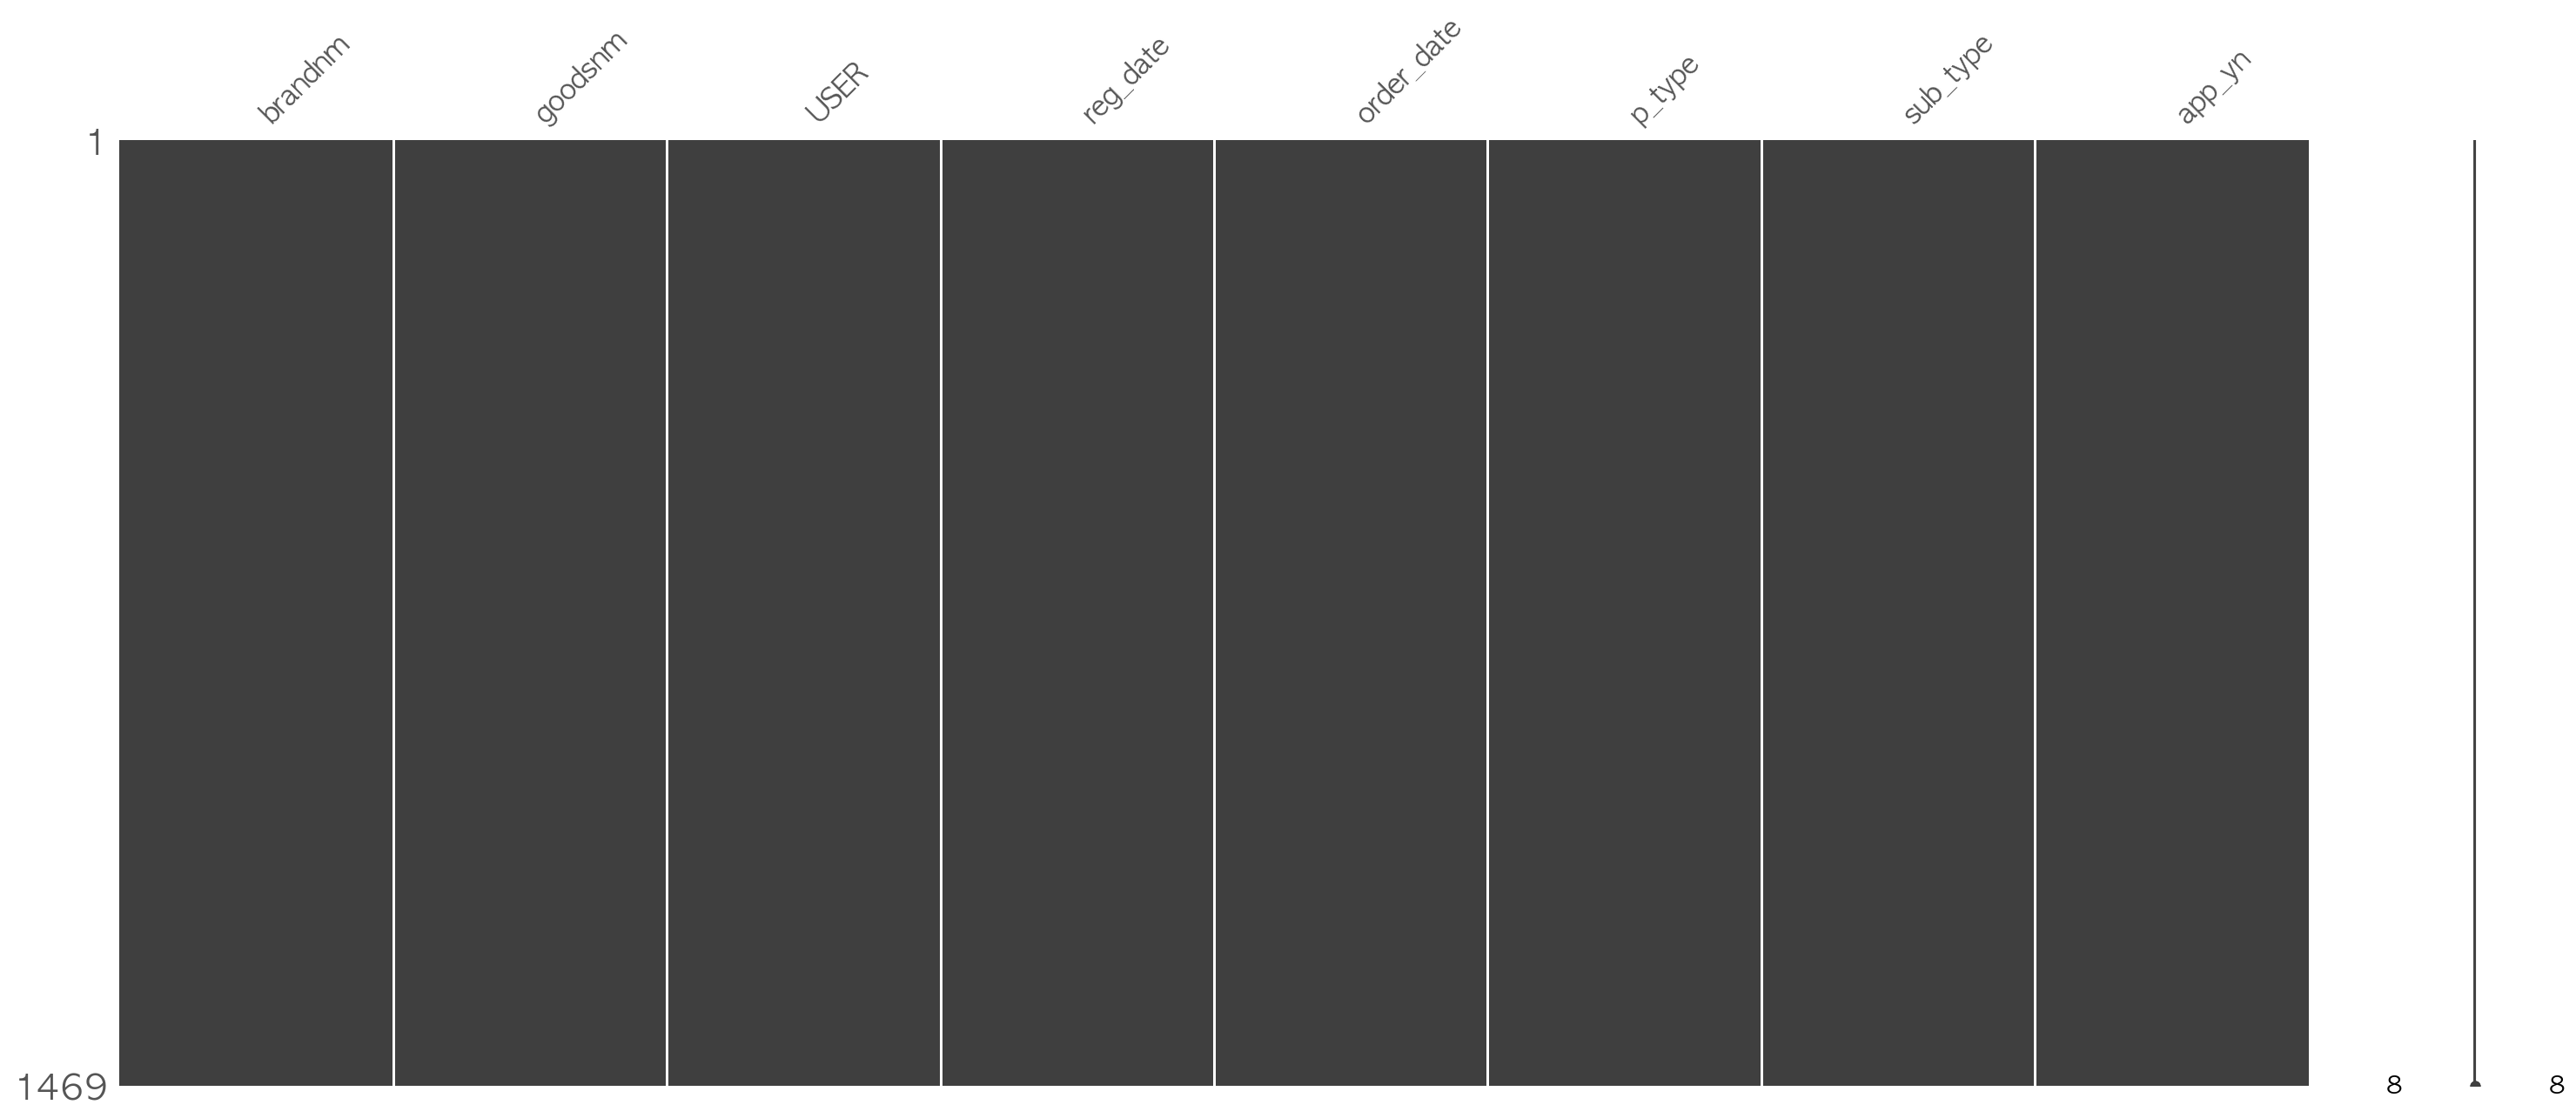

In [5]:
msno.matrix(df)

# 주문 아이템 분석

### EDA를 통해 데이터 살펴보기
* 1. 구매 소요 시간 분석
*  1-1. 가입일, 구매일의 경과일을 살펴보기
* 2. 구매 상품 트렌드 분석
*  2-1. 유저당 주문 수량 분석
*  2-2. 주문 아이템 분석

### 구매 소요 시간 주 단위로 살펴보기

In [6]:
# 당월 n주차 구해보기
# 가입날짜부터 주차별로 나열하기
df['reg_date'] = pd.to_datetime(df['reg_date'])
df['order_date'] = pd.to_datetime(df['order_date'])
df['reg_date_ym']=df['reg_date'].dt.strftime('%y-%m')
df['reg_date_w']='NaN'

#당월 n주차 구하는 함수 
def week_of_month(dt):

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

#당월 n주차 구하기
for idx, (y, m, n) in enumerate(zip(df.reg_date.dt.year, df.reg_date.dt.month, df.reg_date.dt.day)) :
    temp_week=week_of_month(datetime(y,m,n))
    df['reg_date_w'][idx]= temp_week

df['reg_date_ymw']=df.reg_date_ym+'-'+df.reg_date_w.astype(str)

In [7]:
# 주문 날짜도 주차별로 보기
df['order_date_ym']=df['order_date'].dt.strftime('%y-%m')
df['order_date_w']=0
for idx, (y, m, n) in enumerate(zip(df.order_date.dt.year, df.order_date.dt.month, df.order_date.dt.day)) :
    temp_week=week_of_month(datetime(y,m,n))
    df['order_date_w'][idx]= temp_week

df['order_date_ymw']=df.order_date_ym+'-'+df.order_date_w.astype(str)

In [8]:
# 필요없는 column 드랍
drop_cols=['reg_date_ym','reg_date_w','order_date_w','order_date_ym','order_date_w','reg_date_w']

data = df.drop(drop_cols, 1)

In [9]:
# 주차별 주문 수 확인

order = data.groupby('order_date_ymw').count()['USER'].reset_index()

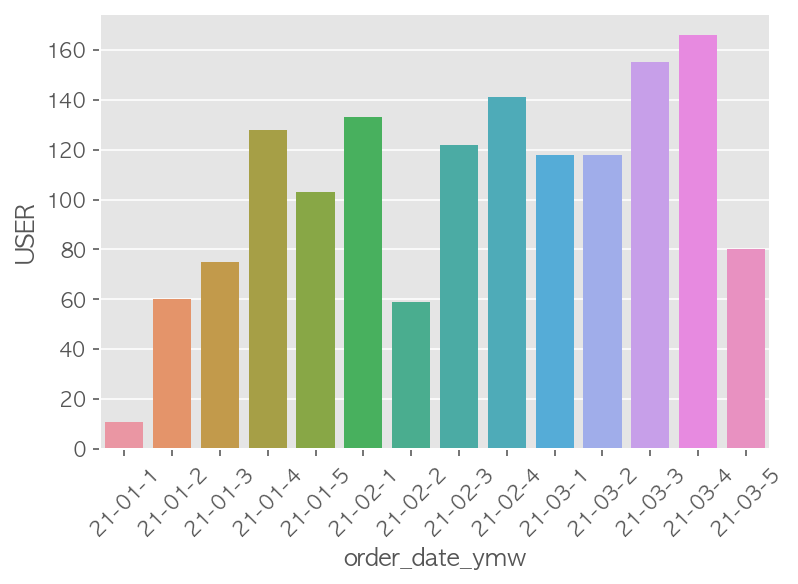

In [10]:
sns.barplot(data=order, x='order_date_ymw', y='USER')
plt.xticks(rotation = 45)
plt.show()

### 월별로도 확인

In [11]:
month_list = [
    (data['order_date'] <='2021-01-31'),
    (data['order_date'] <='2021-02-28') & (data['order_date'] >'2021-01-31'),
    (data['order_date'] <='2021-03-31') & (data['order_date'] >'2021-02-28')]

indi_list = ['1월구매자', '2월구매자', '3월구매자']

data['월별구매자'] = np.select(month_list, indi_list)

In [12]:
buyer_type = data.groupby(['sub_type', '월별구매자']).count()['USER'].sort_values(ascending=False).reset_index()
buyer_type

,sub_type,월별구매자,USER
0,BA,3월구매자,310
1,BA,2월구매자,234
2,BA,1월구매자,148
3,D,3월구매자,128
4,O,2월구매자,97
5,O,3월구매자,87
6,O,1월구매자,83
7,D,2월구매자,69
8,T,3월구매자,65
9,D,1월구매자,64


### 월별로 구매가 늘어나며 가방과 드레스의 렌탈 상승이 보임

<AxesSubplot:xlabel='sub_type', ylabel='USER'>

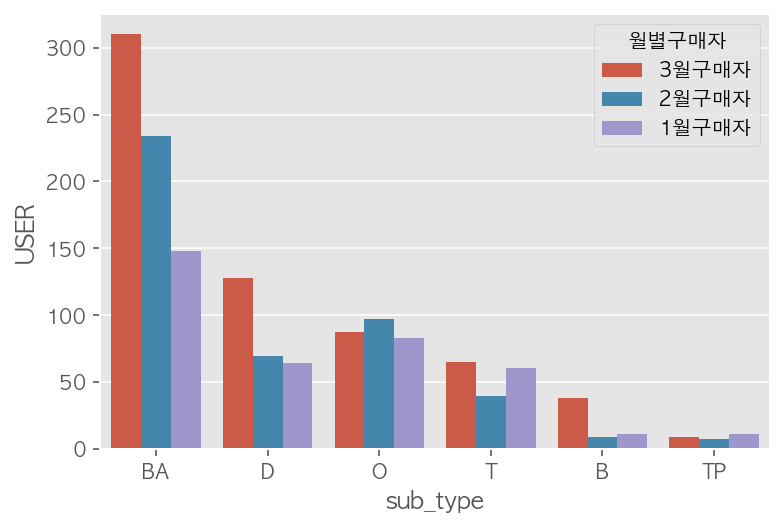

In [13]:
sns.barplot(data = buyer_type, x='sub_type', y='USER', hue='월별구매자')

# 주문 아이템 분석
- 브랜드 별 선호도, 아이템 카테고리별 선호도 분석
- 신규 유저들의 구매 트렌드 파악

## 브랜드 별 선호도 분석

In [14]:
# 브랜드 갯수 총 252개
len(df['brandnm'].unique())

258

In [15]:
df['brandnm'].unique()

array(['Gucci', 'El estilo de Claire', 'Danha', 'Burberry London',
       'Prada', 'Max Mara', 'Molliolli', 'Sandro', 'Louis Vuitton',
       'Tory Burch', 'Chloe', 'Time', 'The Izzat', 'Mojosphine',
       'Ted Baker', '& Other Stories', 'Fendi', 'Balmain', 'Celine',
       'Burberry', 'Chanel', 'Dior', 'Bottega Veneta', 'Plastic Island',
       'Reneevon', 'Sorry Too Much Love', 'Saint Laurent', 'Miu Miu',
       'Yves Saint Laurent', 'Zooc', 'Vivienne Westwood',
       'Maison Kitsune', 'Margarin fingers', 'The Tint', 'Love Moschino',
       'Michaa', 'Vivienne Westwood Red Label', 'MSGM', 'Christian Dior',
       'It michaa', 'SJSJ', 'Amsale', 'Imvely', 'Chi Chi London', 'Maje',
       'Biker Starlet', 'Thom Browne', 'Jill By Jill Stuart',
       'Comme des Garcons', 'Nain', 'Dolce & Gabbana', 'Givenchy',
       'Salvatore Ferragamo', 'Andersen-Andersen', 'A.P.C.',
       'Self-portrait', 'Sonia Rykiel', 'Diane von Furstenberg',
       'Hugo Boss', 'Baum Und Pferdgarten', 'BCBG', '

In [16]:
df.groupby('brandnm').count()['USER'].describe()

count   258
mean      6
std      18
min       1
25%       1
50%       1
75%       3
max     232
Name: USER, dtype: float64

### 브랜드 인기 순위 top 20 확인

In [17]:
top_20 = data.groupby(['brandnm', 'sub_type']).count()['USER'].sort_values(ascending=False)[:24].reset_index()
top_20

,brandnm,sub_type,USER
0,Gucci,BA,204
1,Saint Laurent,BA,84
2,Louis Vuitton,BA,77
3,Chanel,BA,75
4,Prada,BA,38
5,Yves Saint Laurent,BA,34
6,Burberry,O,30
7,Fendi,BA,23
8,Celine,BA,20
9,Max Mara,O,18


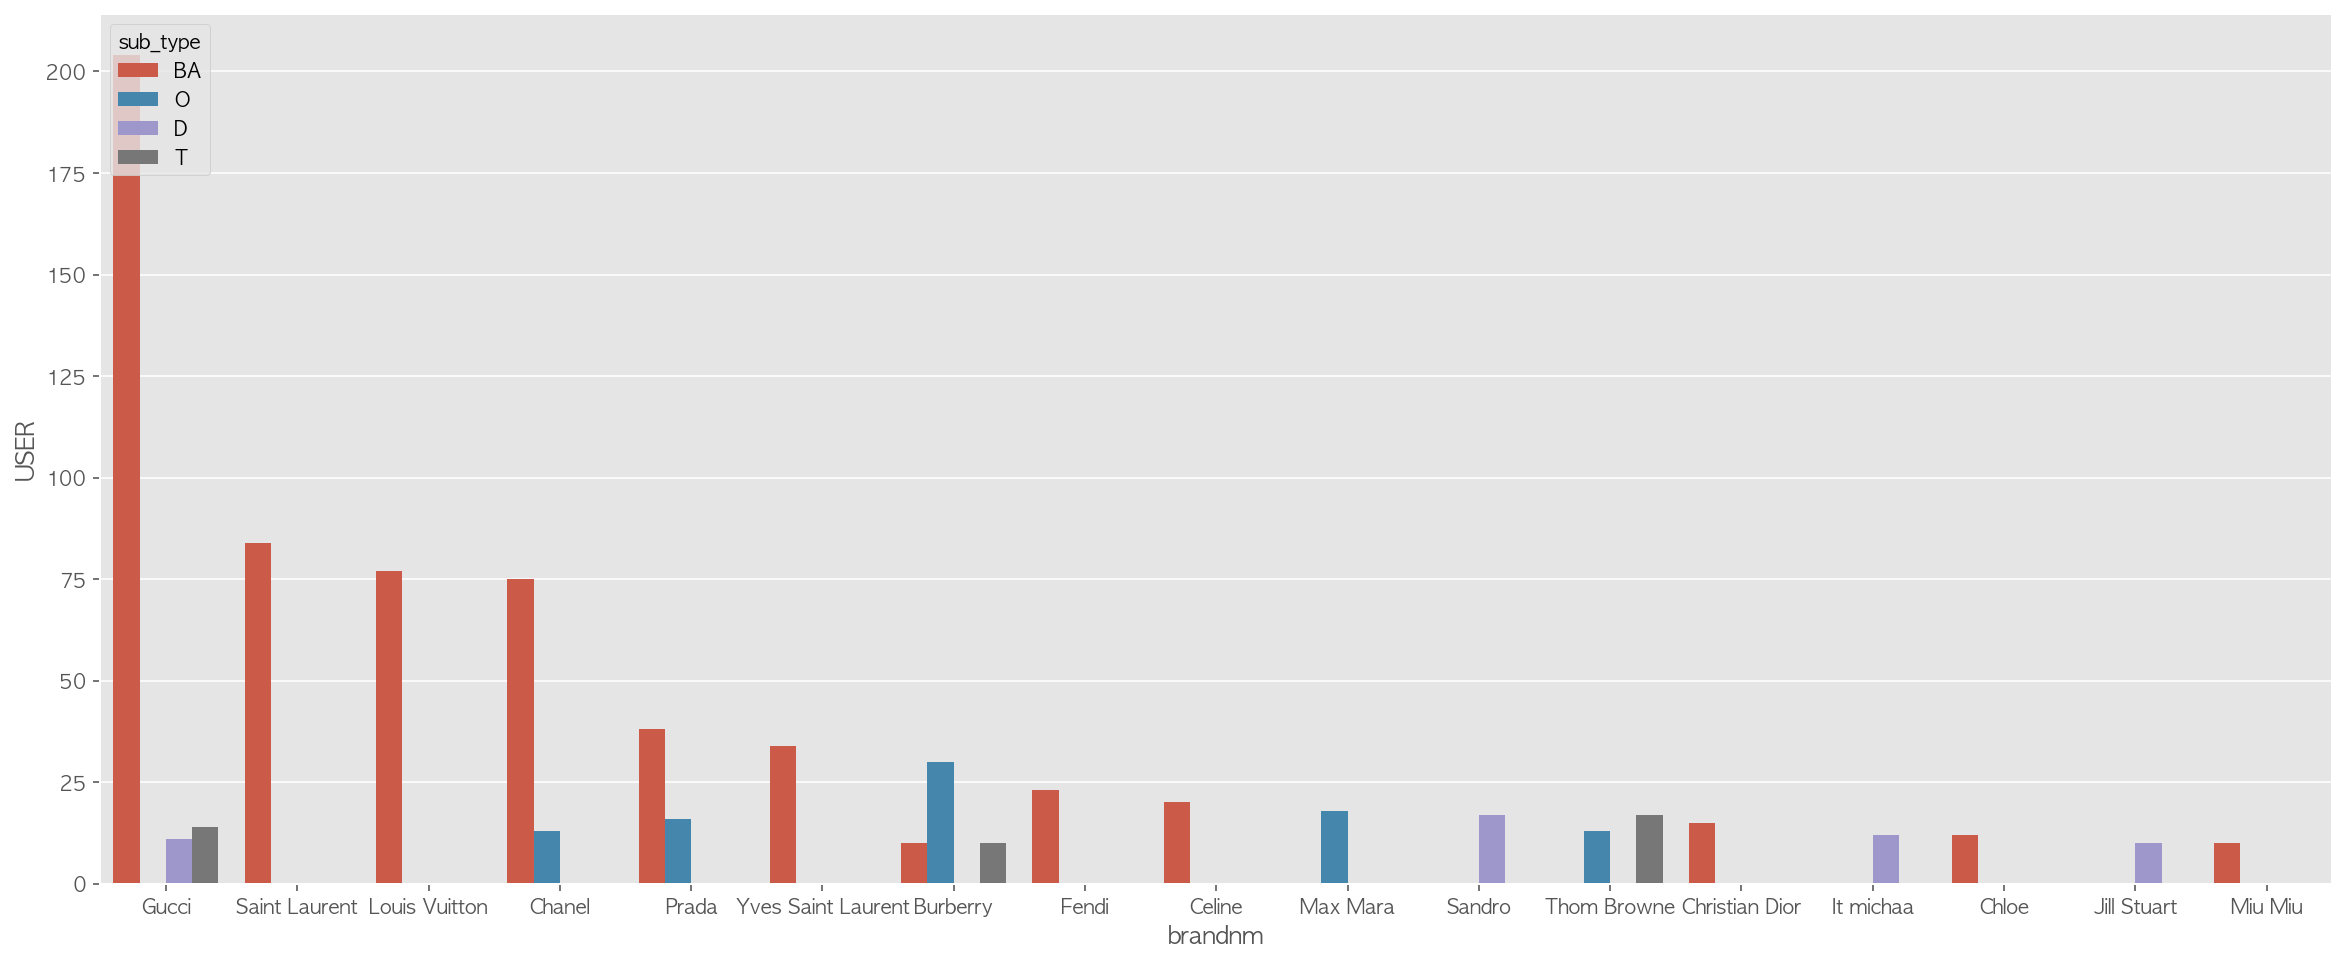

In [18]:
plt.figure(figsize=(20,8))
sns.barplot(data=top_20, x='brandnm', y='USER', hue='sub_type')

plt.show()

### 브랜드 인기 top10

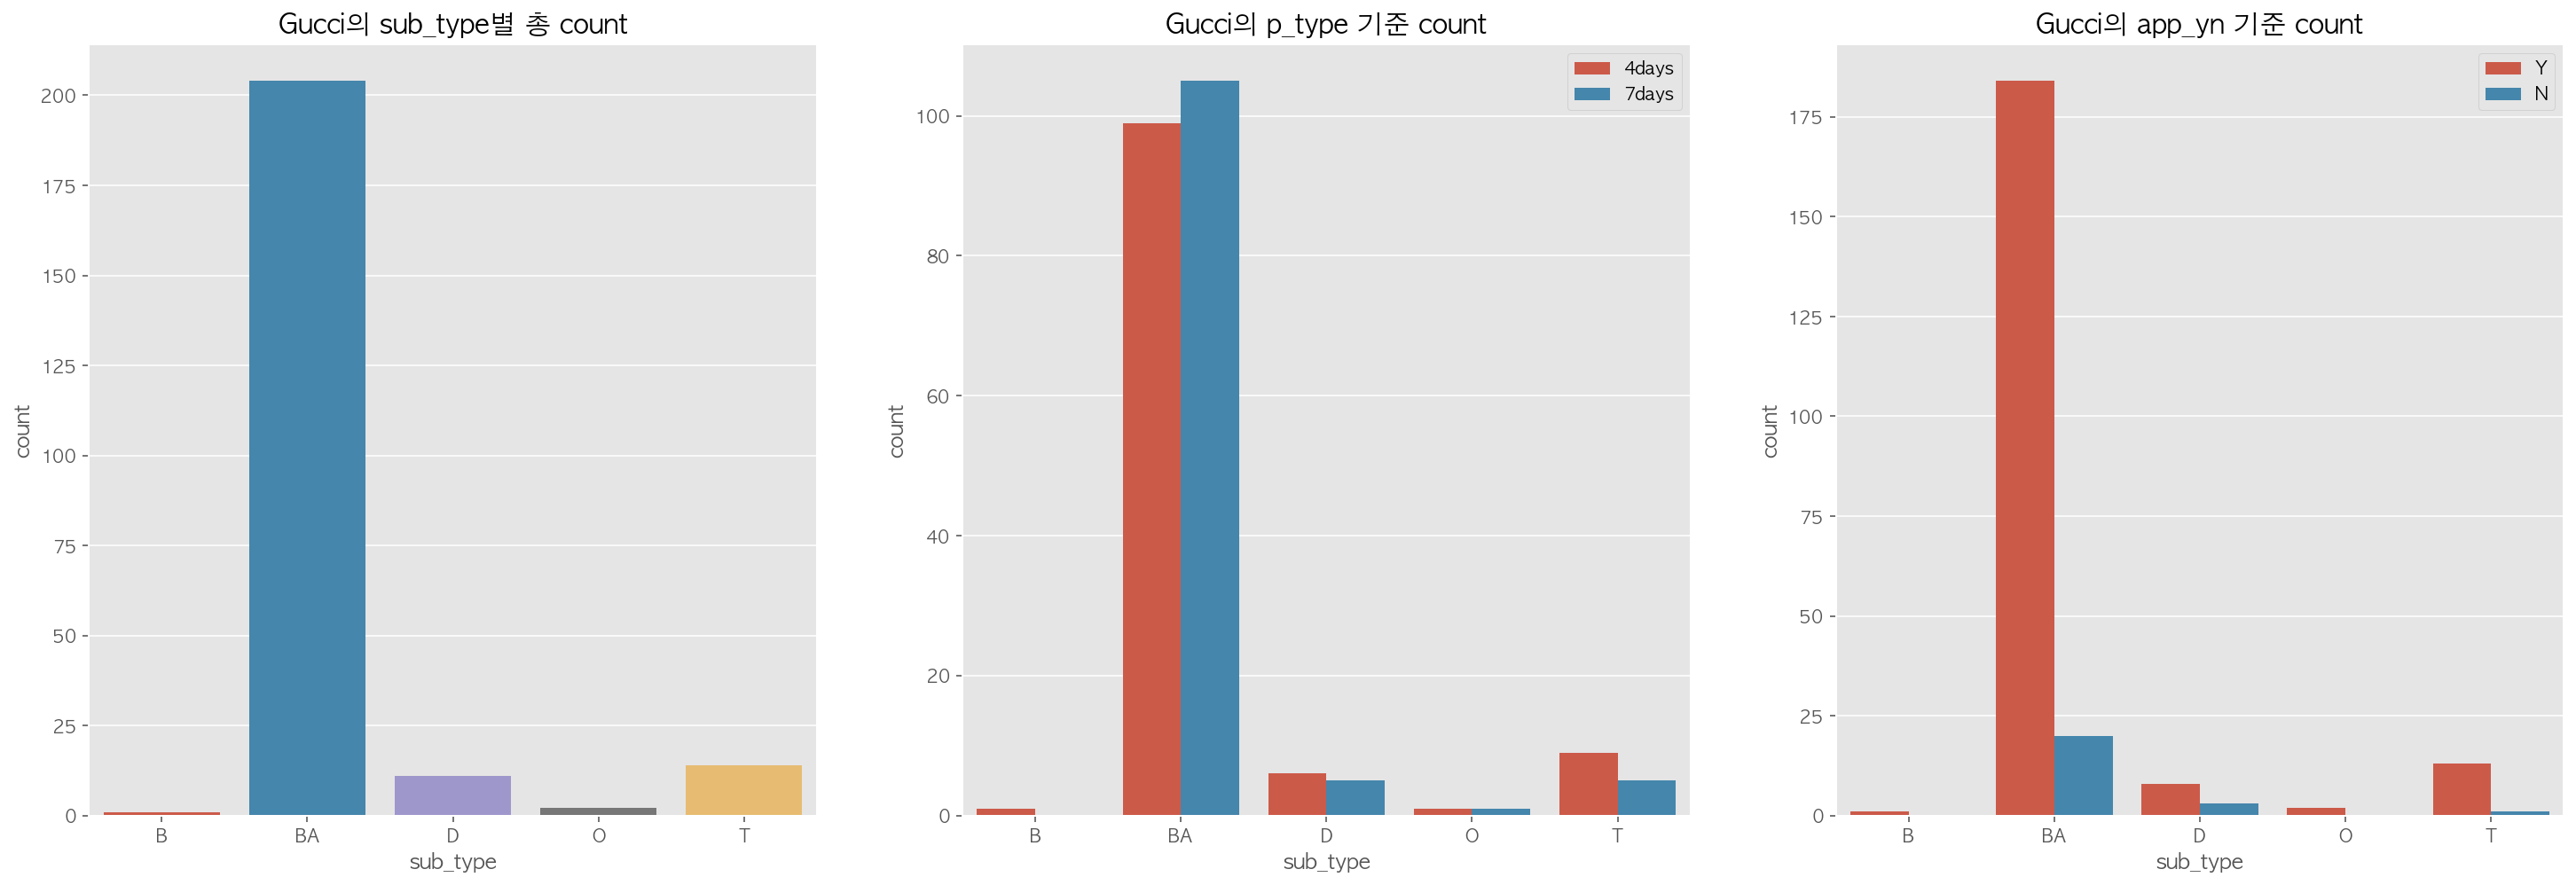

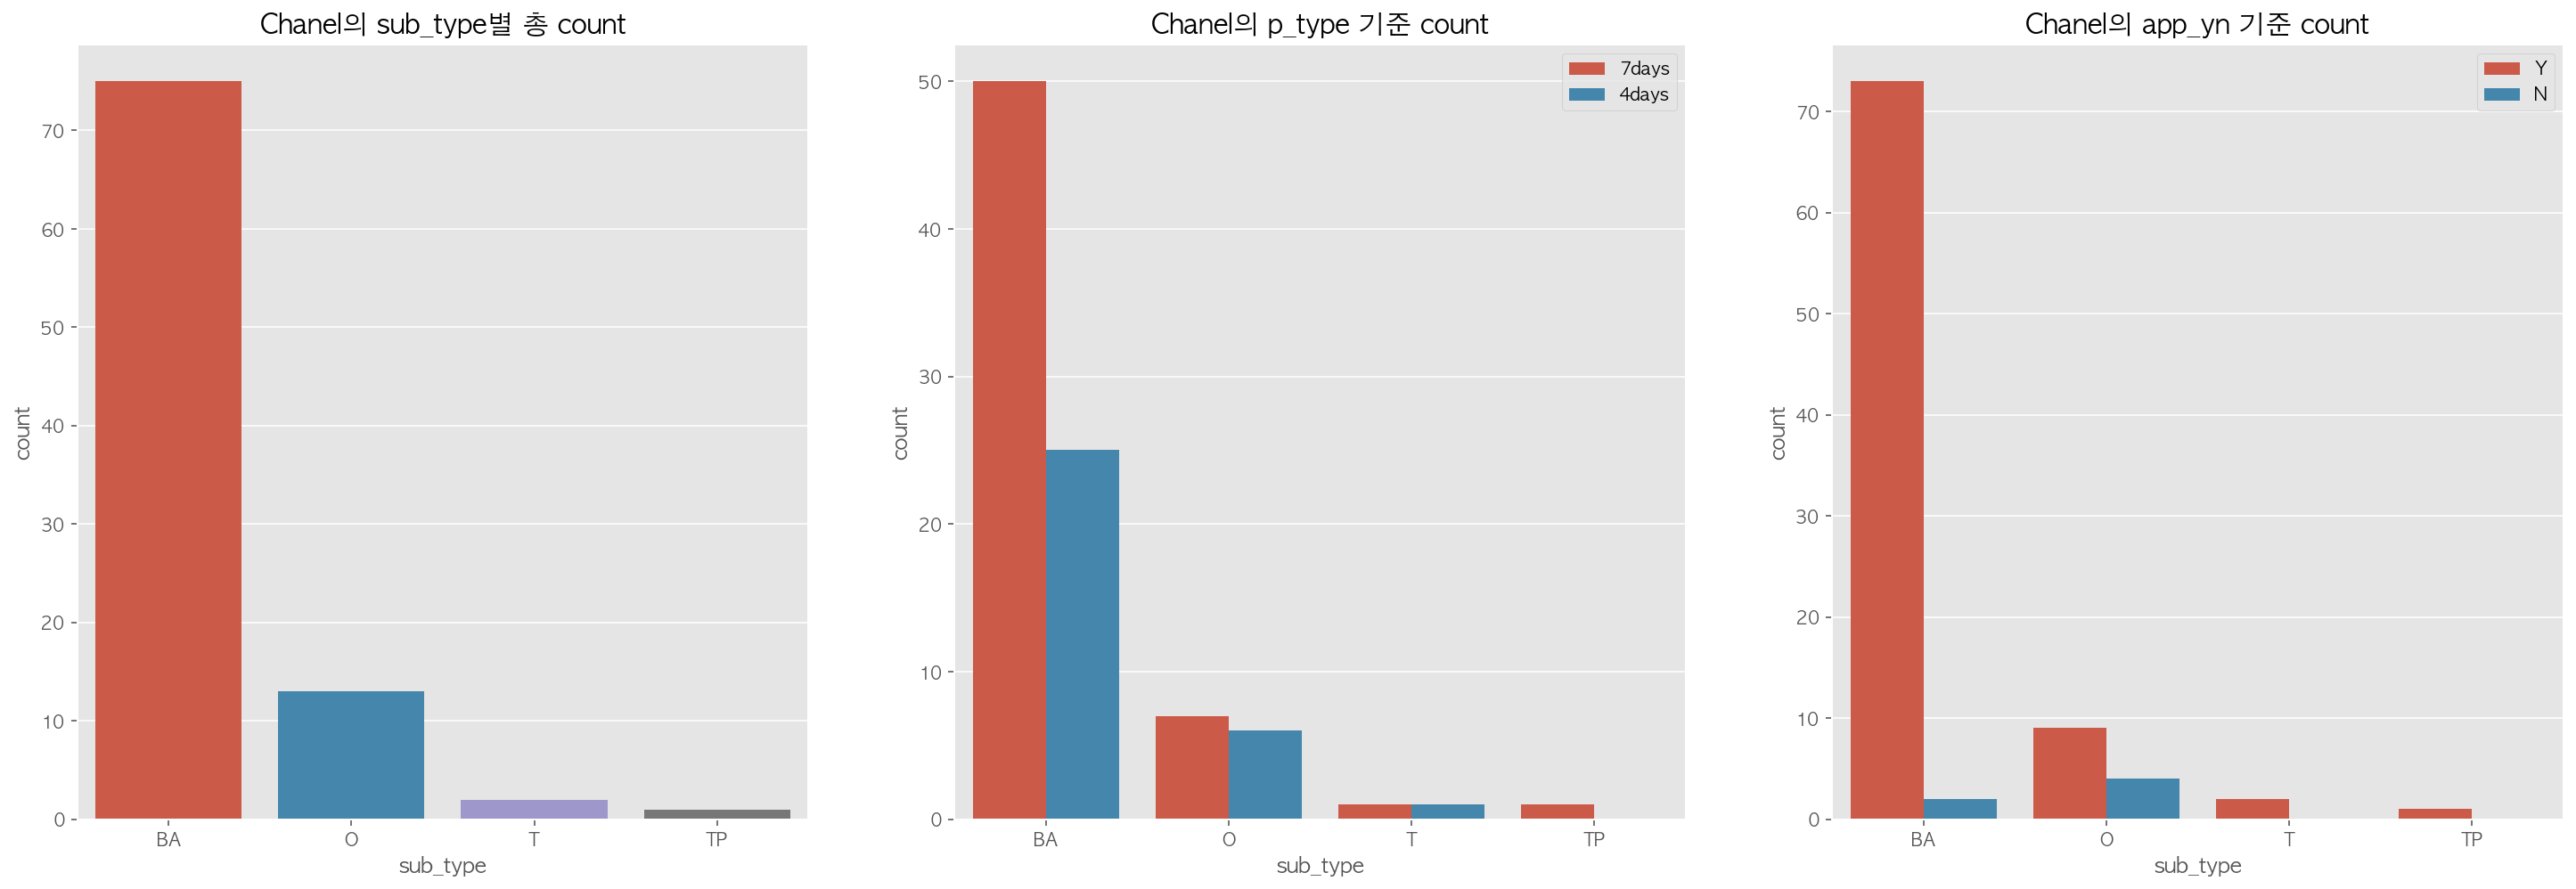

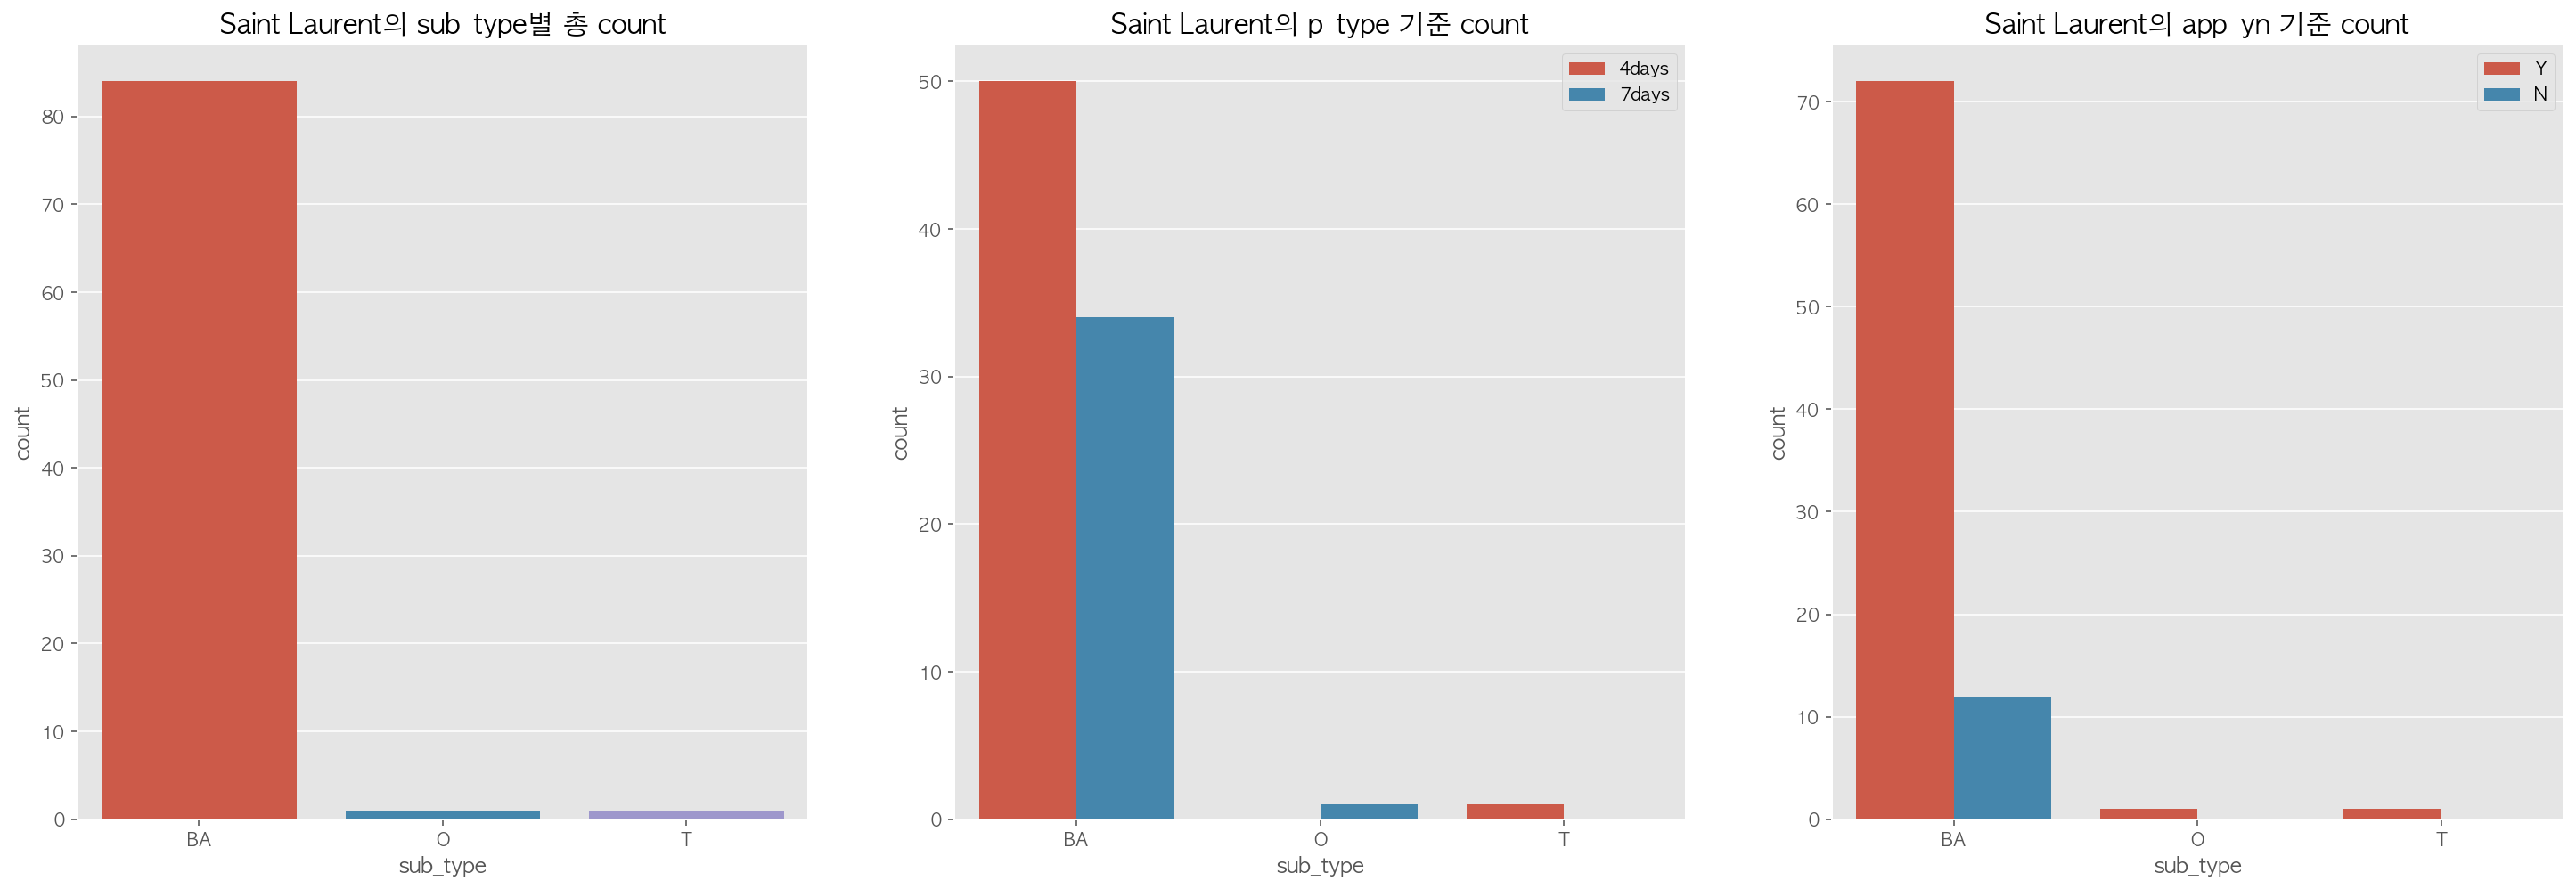

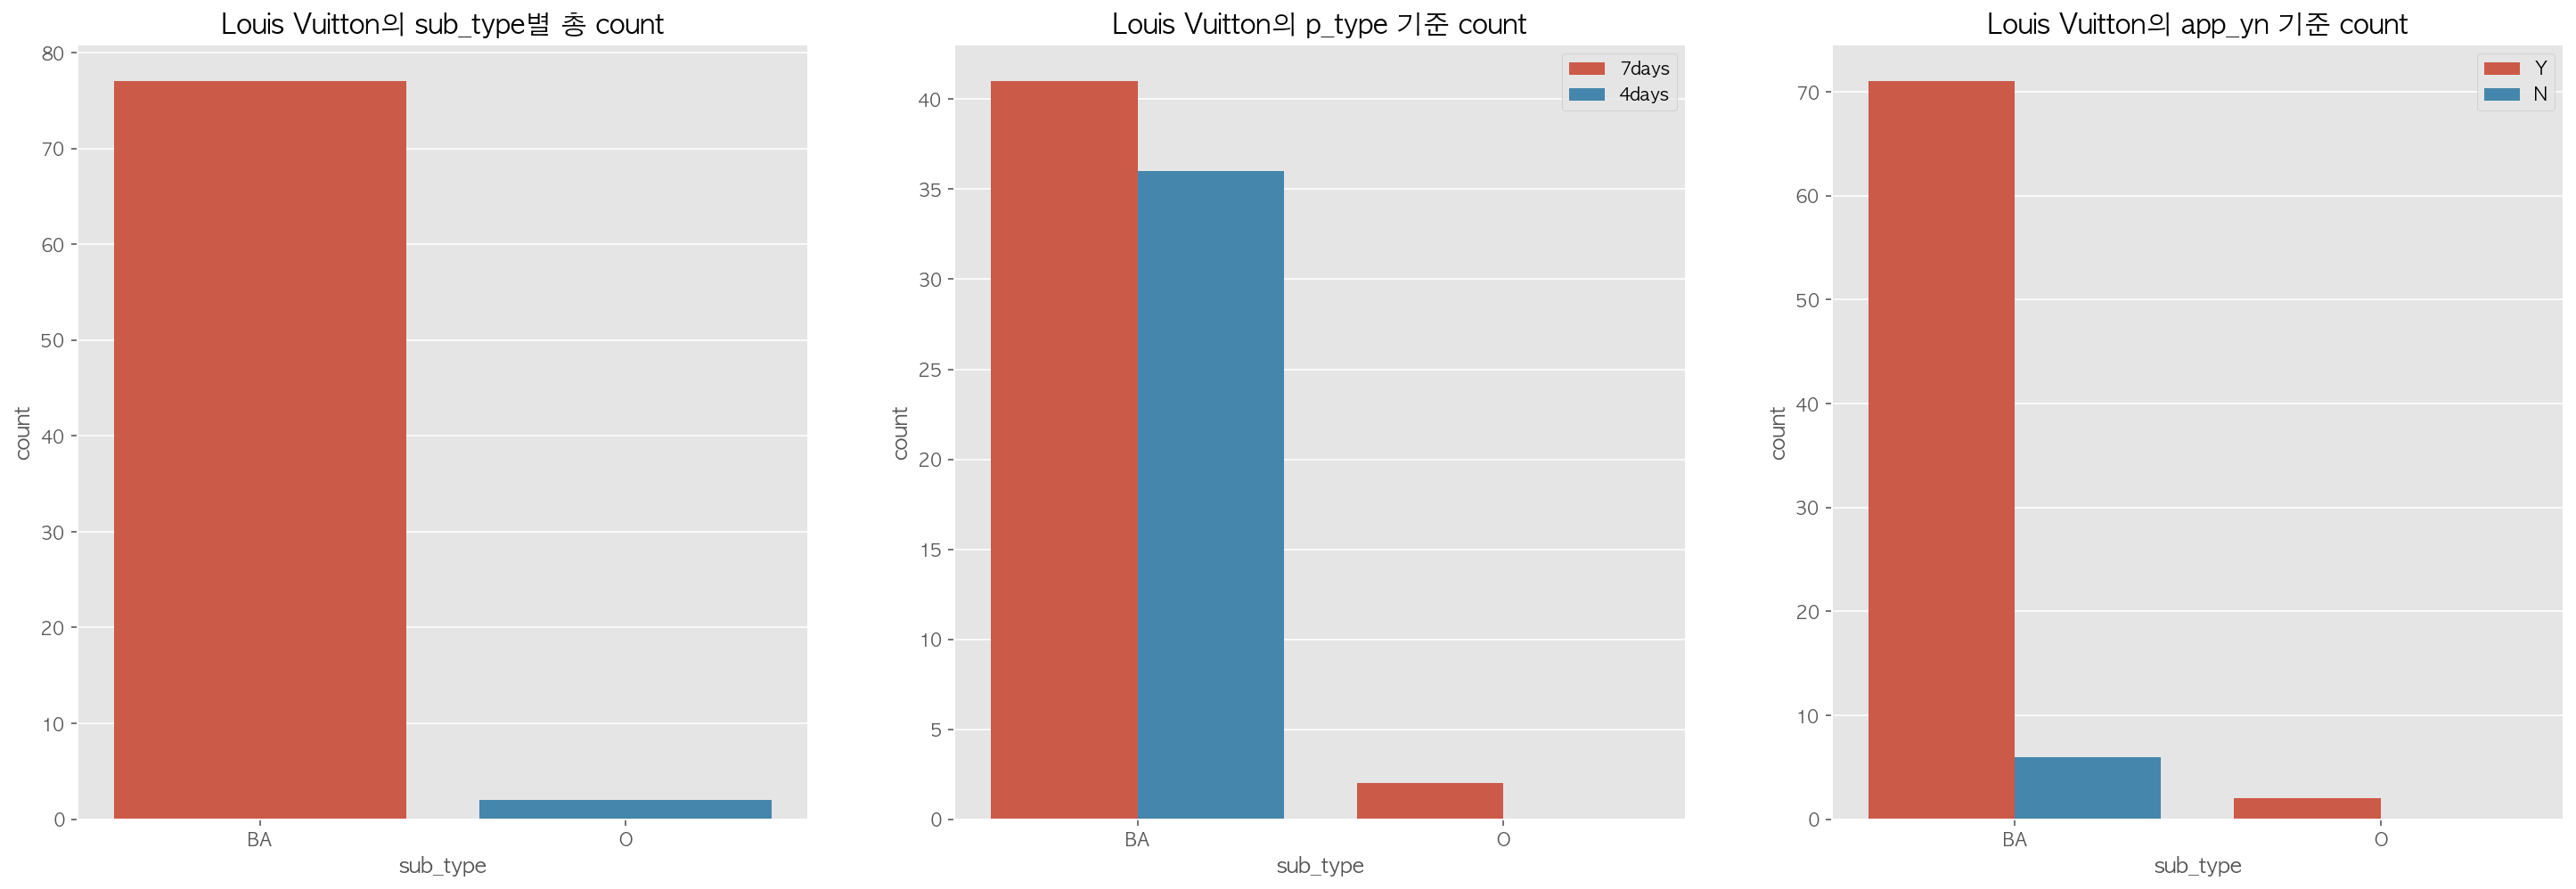

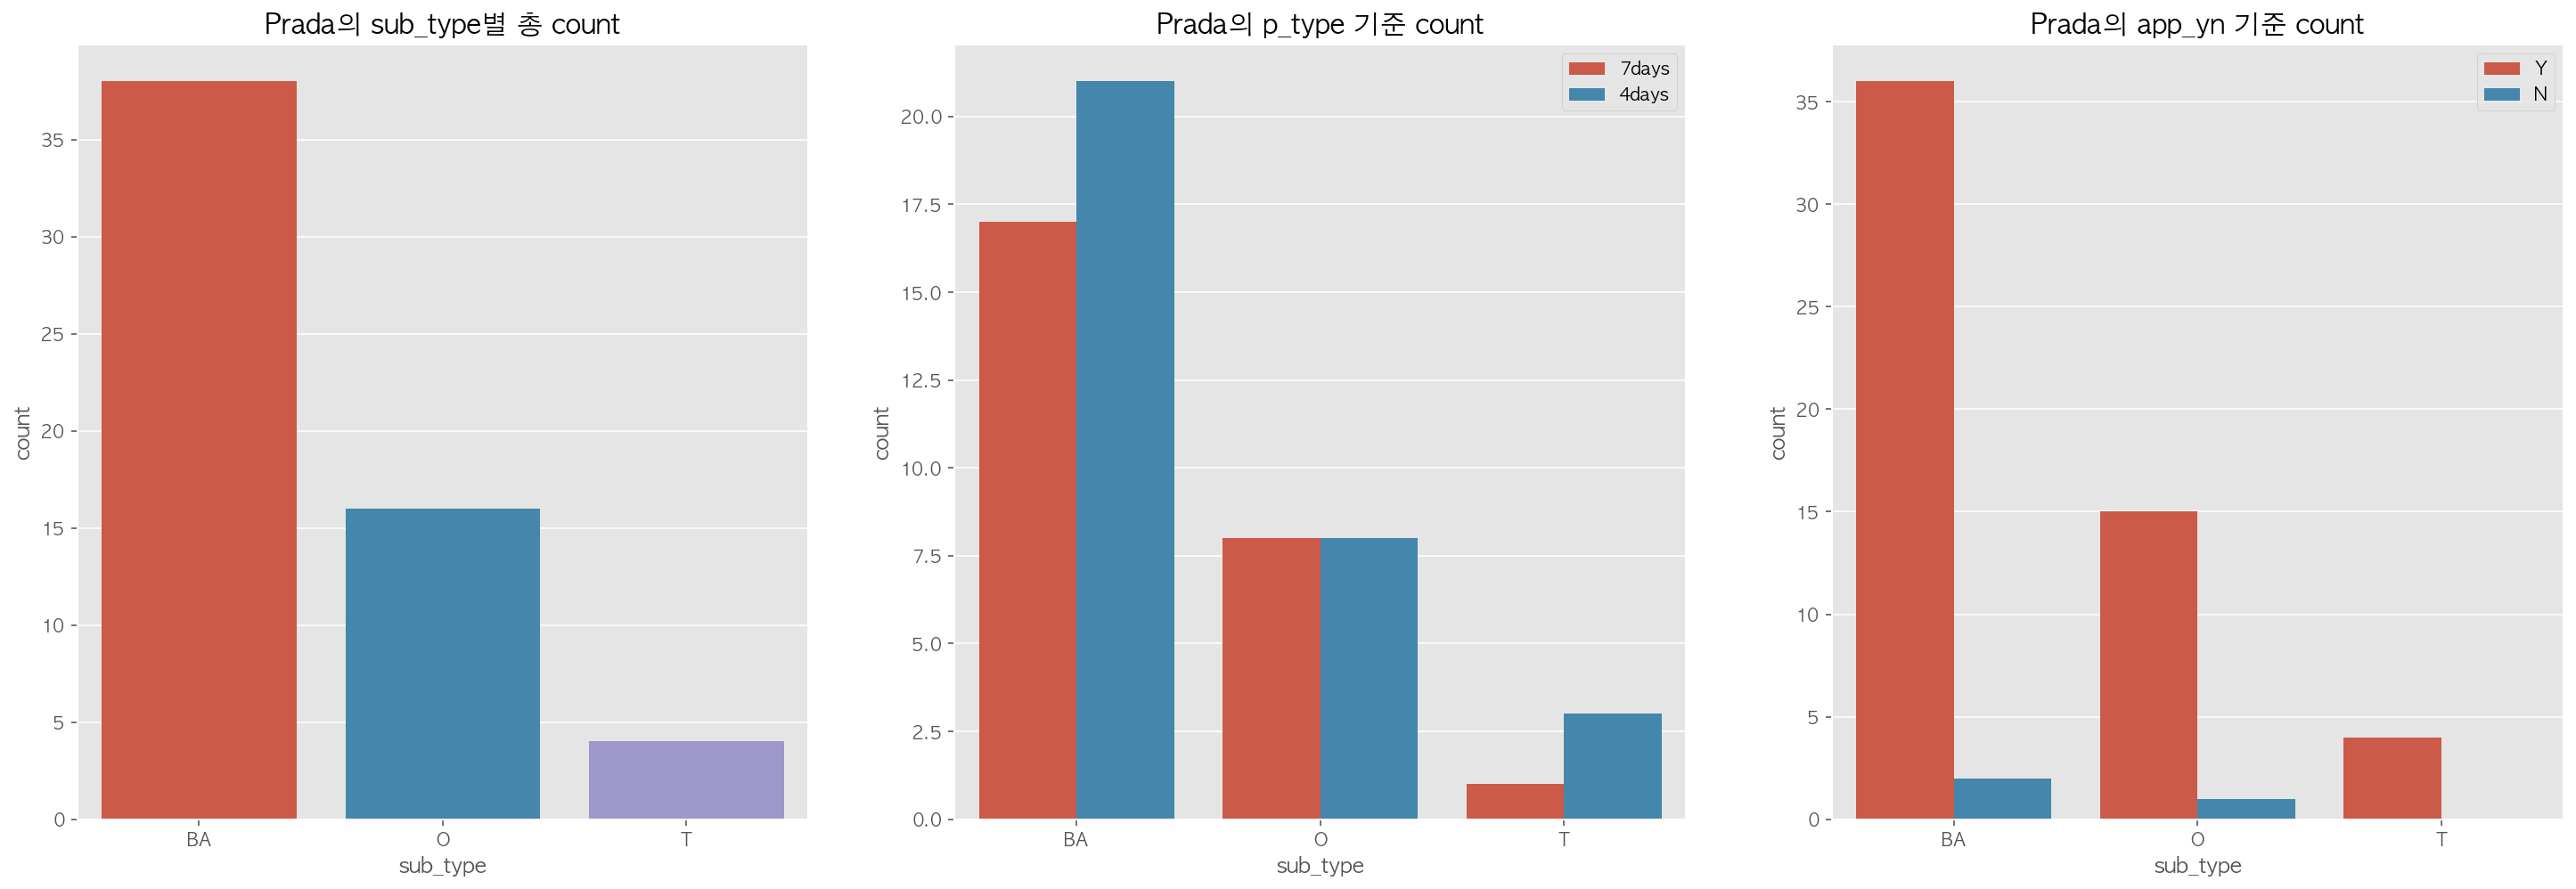

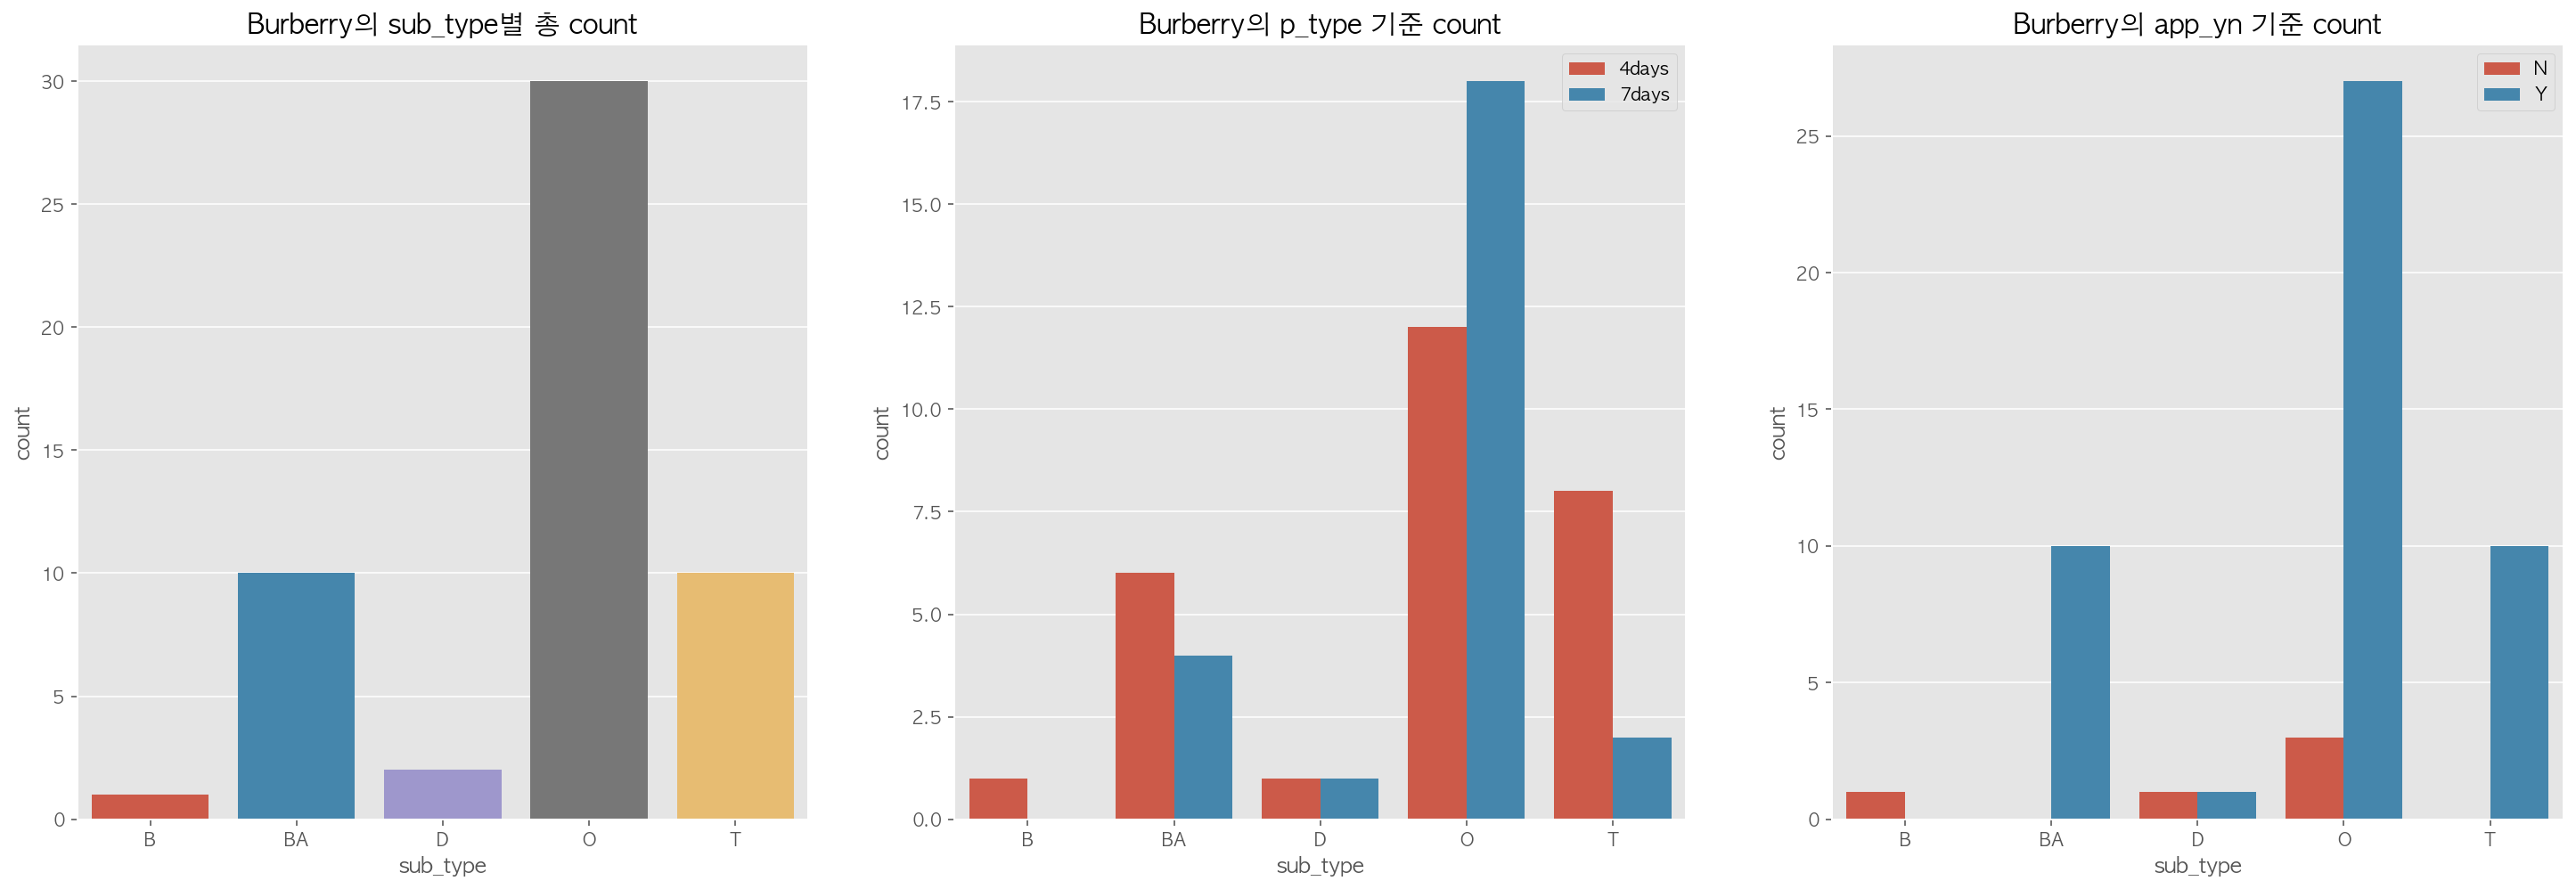

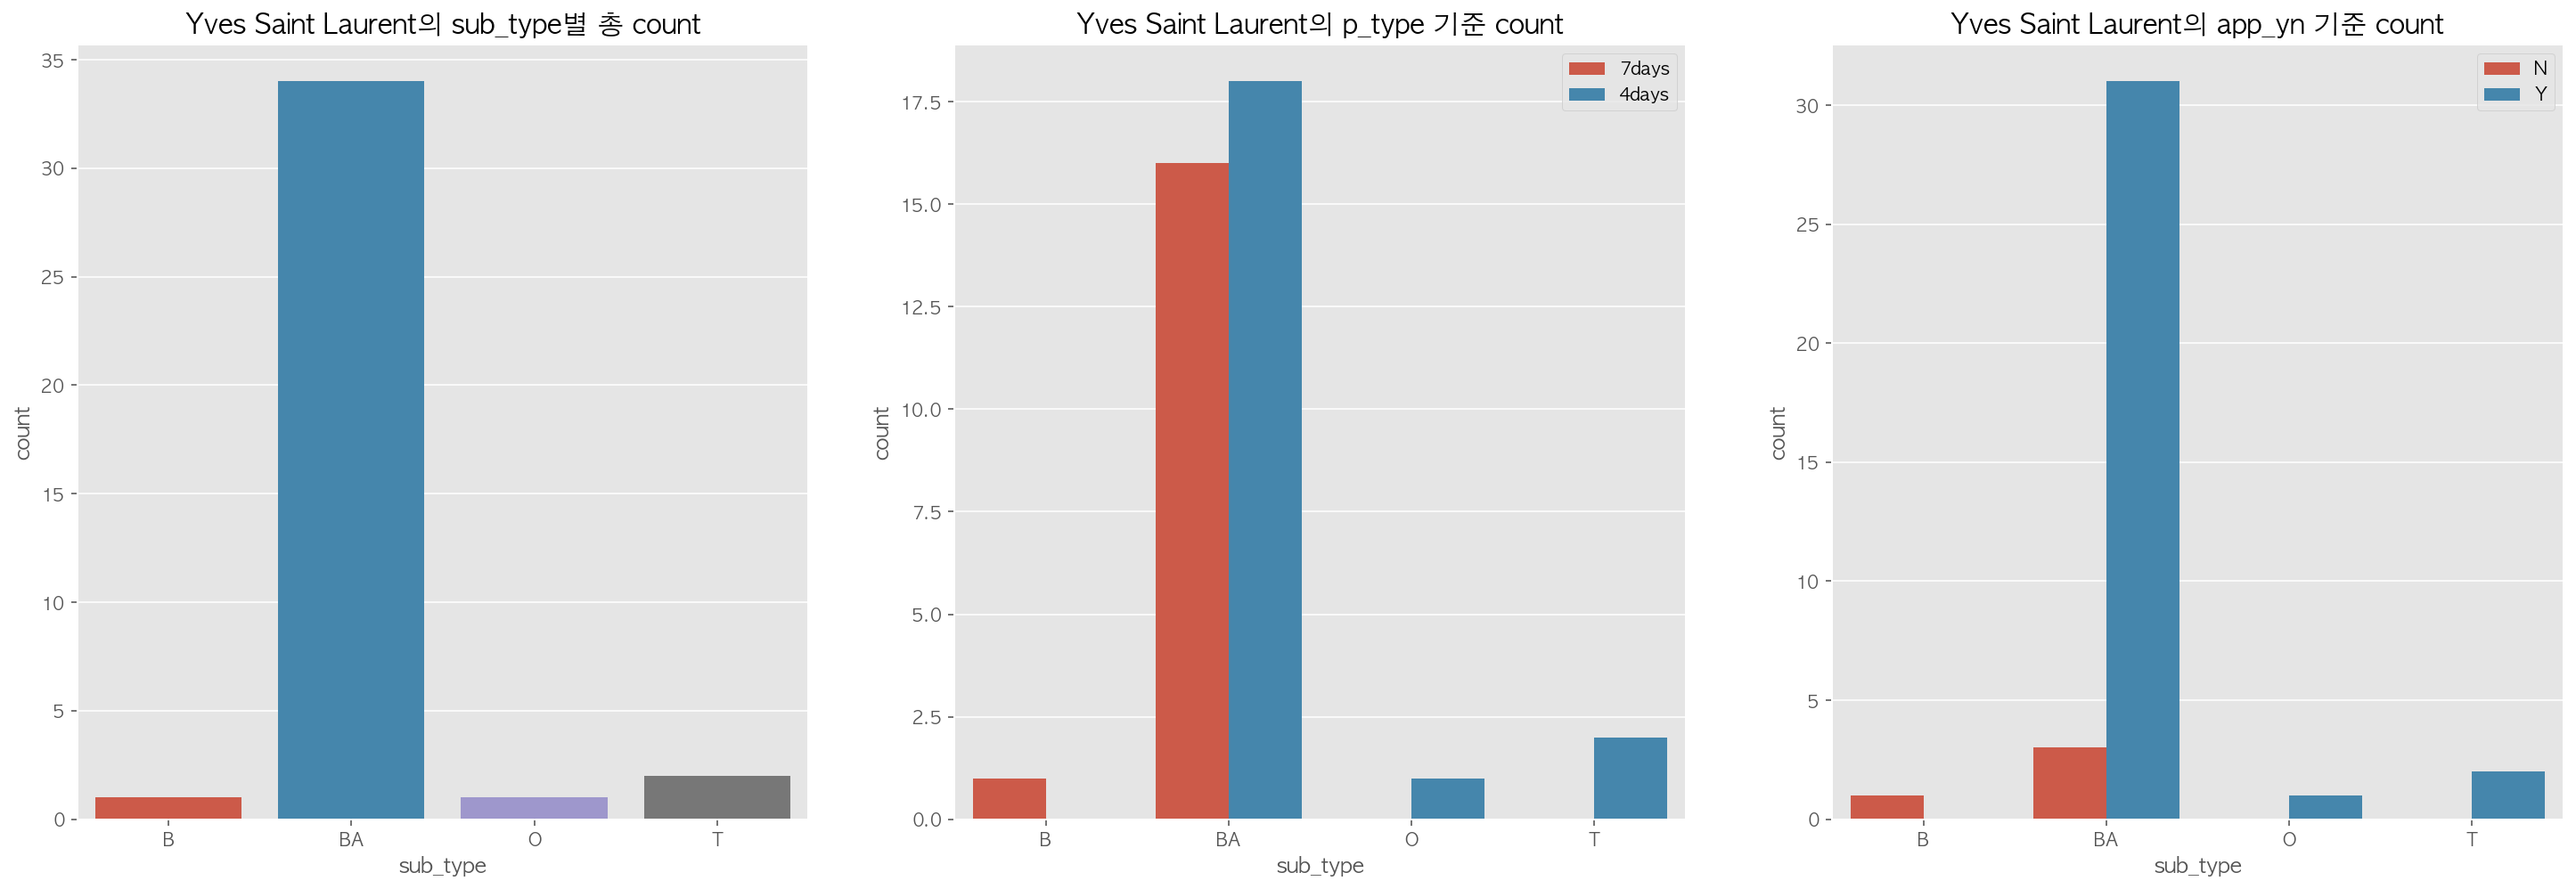

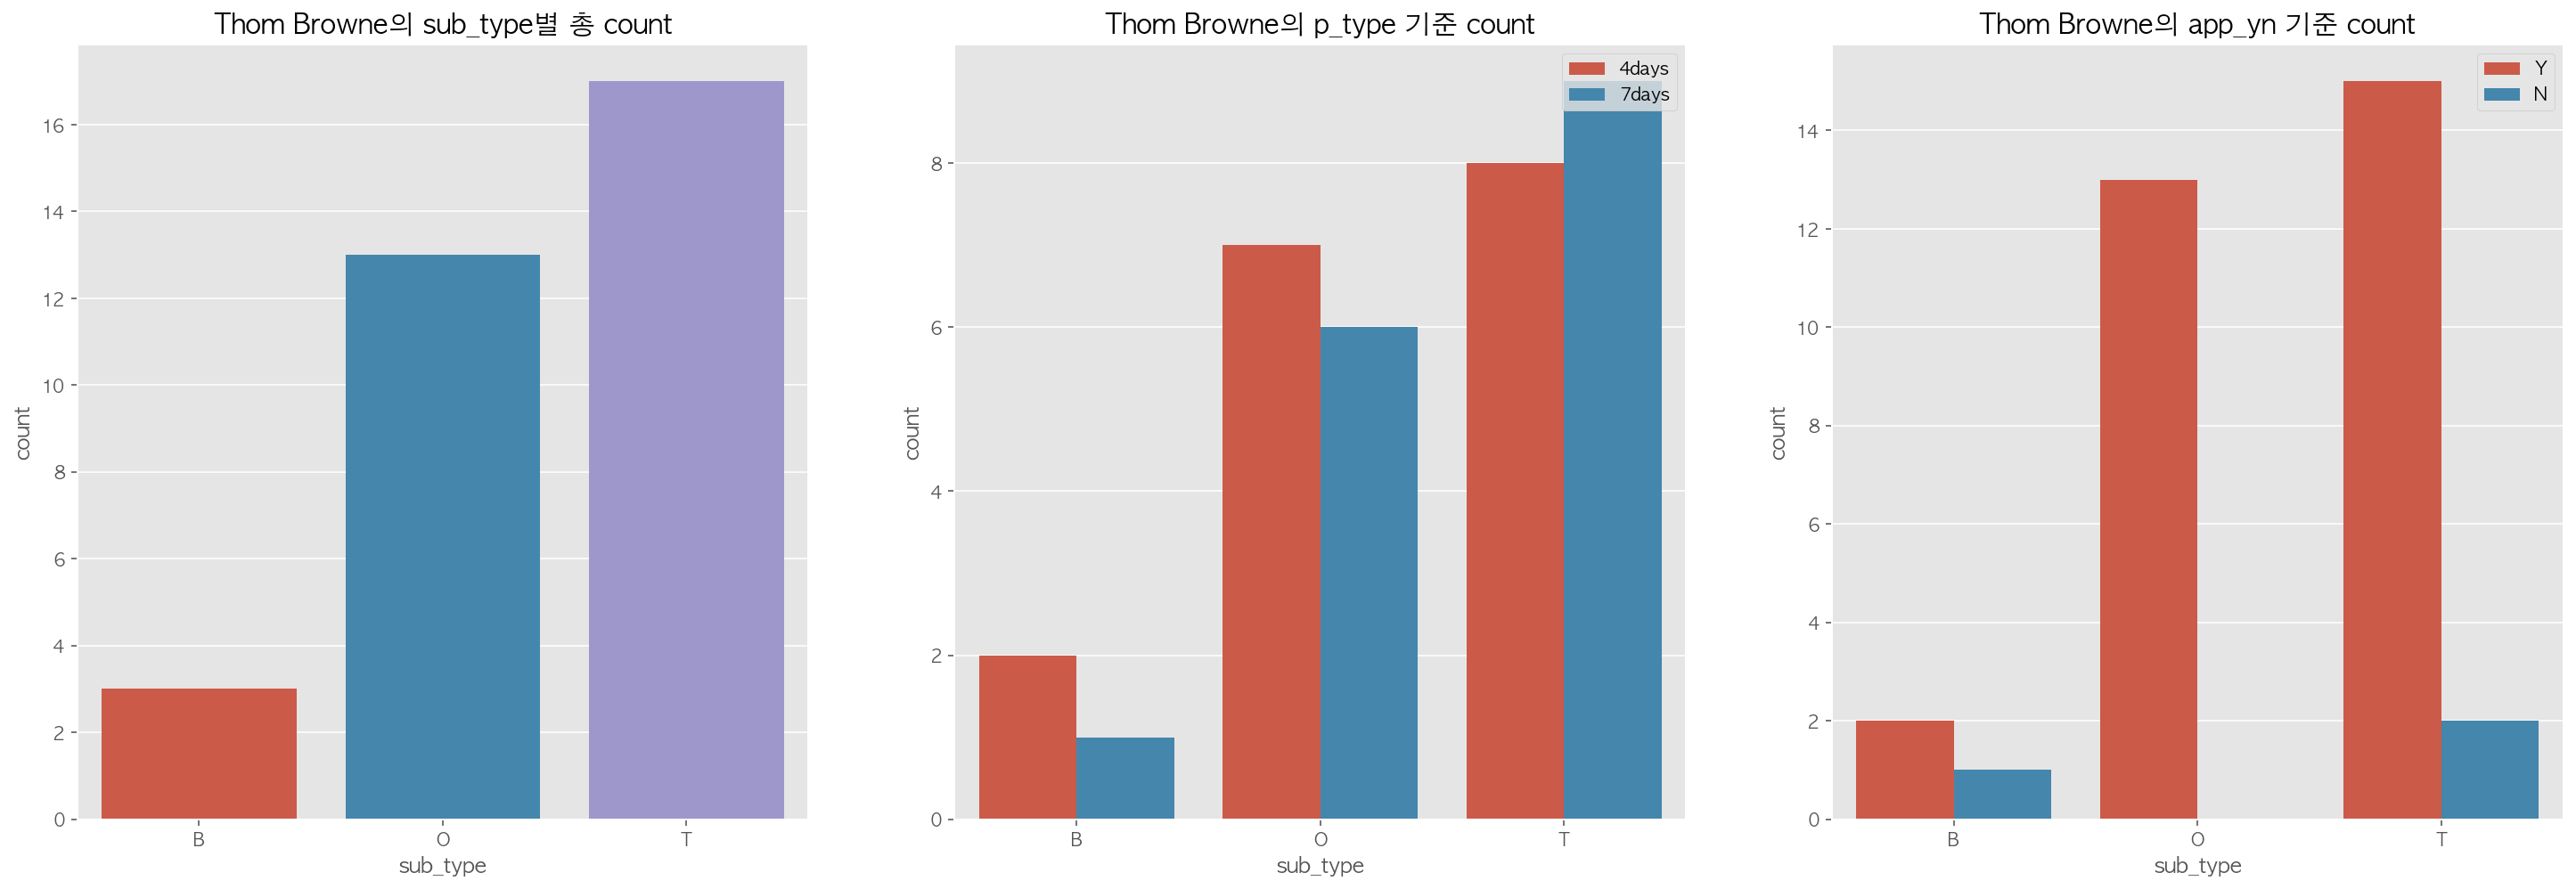

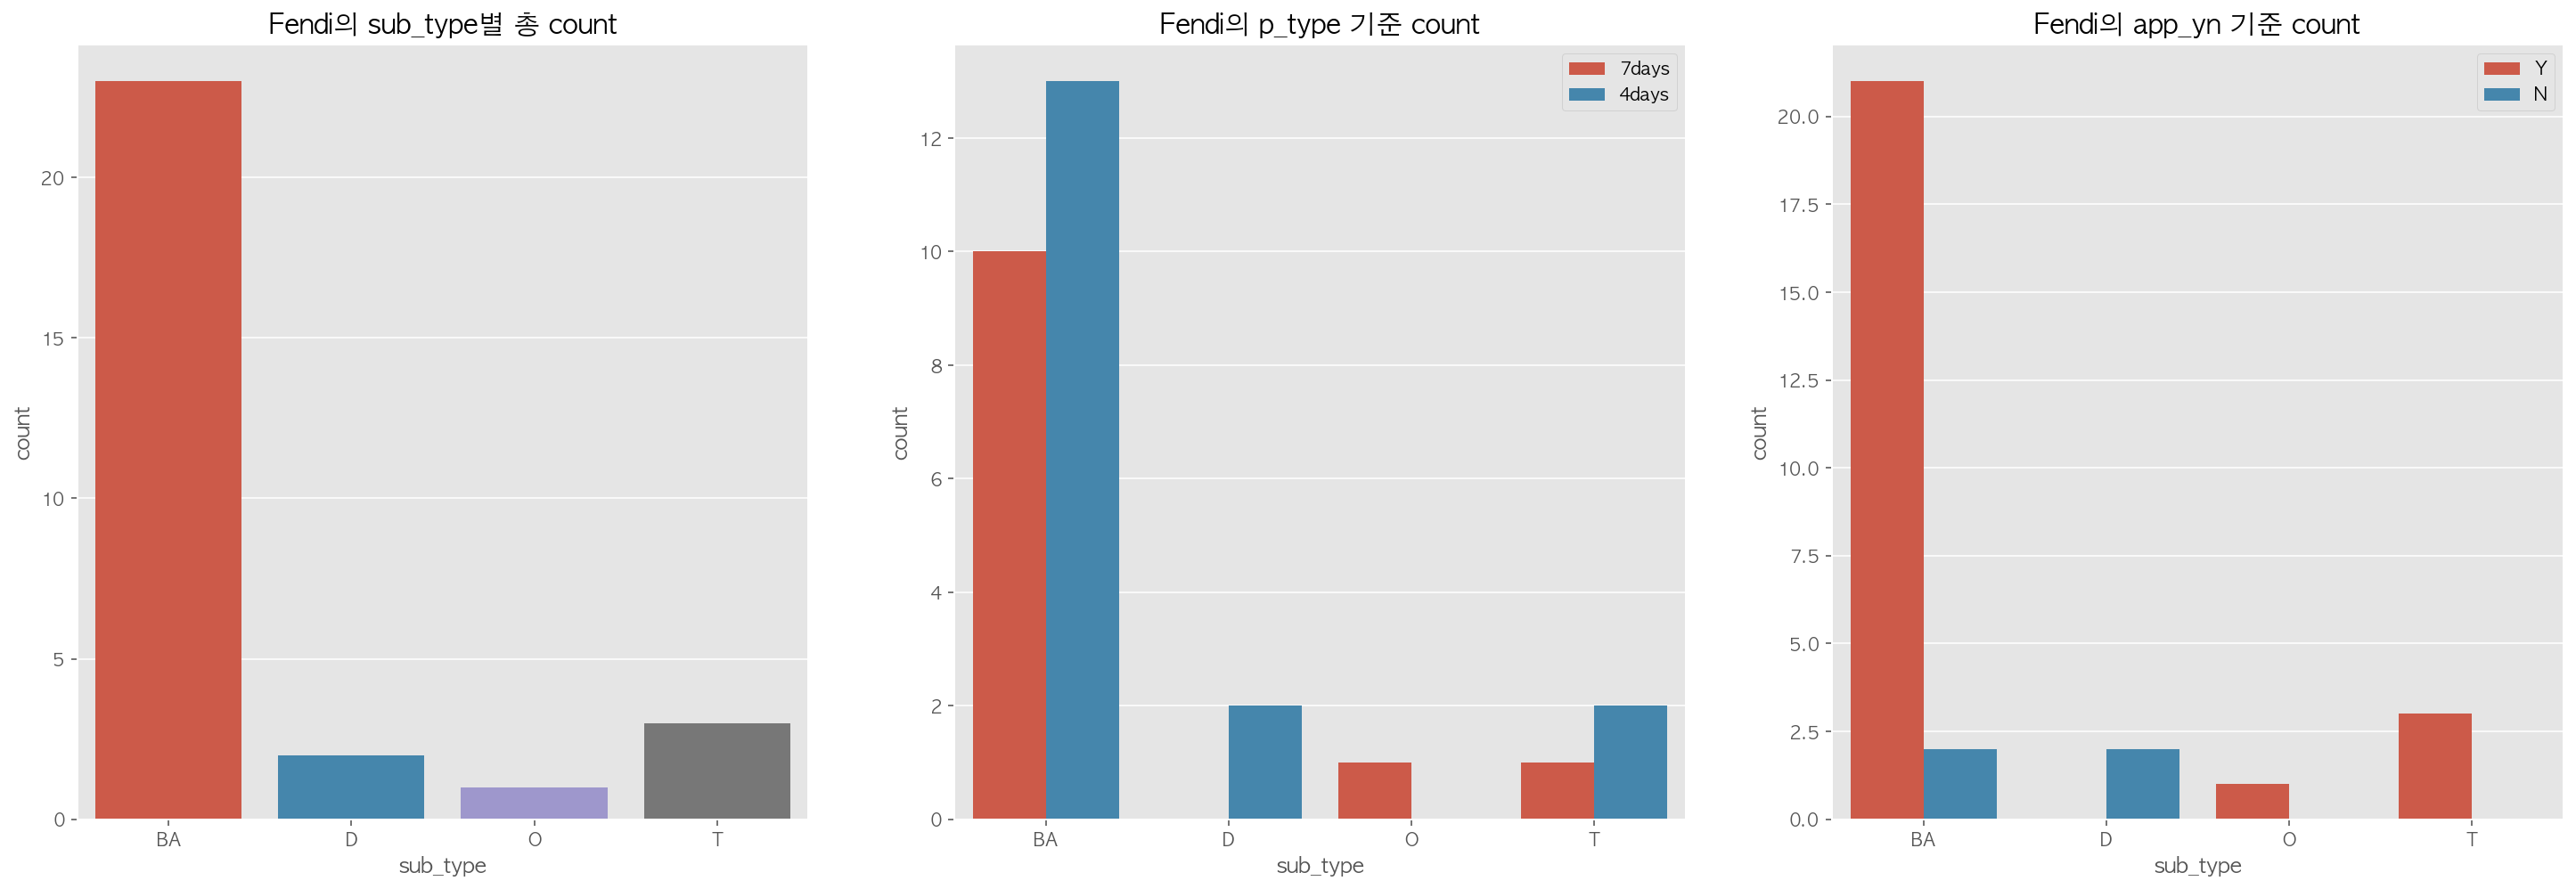

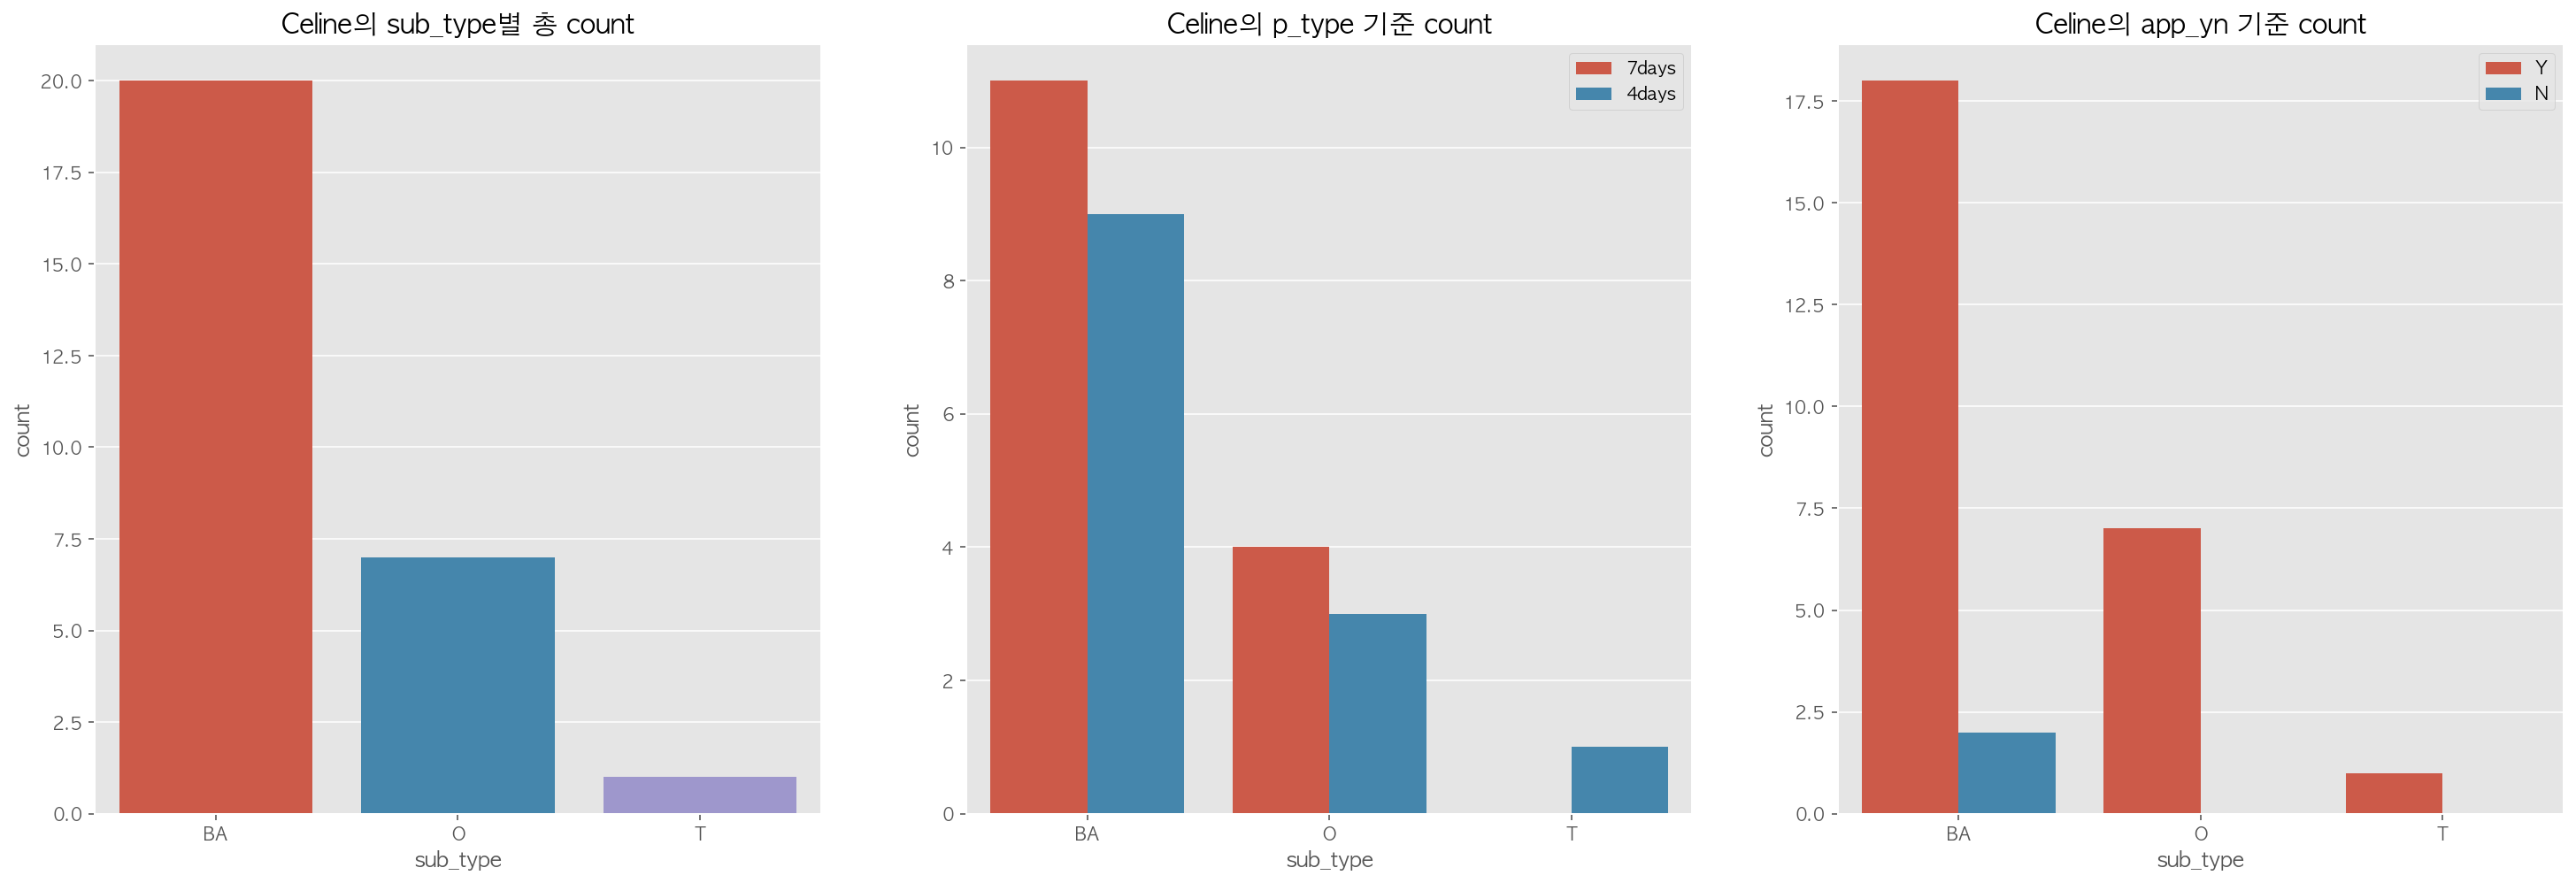

In [19]:
brand_top10 = df.groupby('brandnm').count().sort_values(by='USER',ascending=False)['USER'].head(10).index

# 그래프 그리기
for i in brand_top10:
    brand = df[df['brandnm']==i].sort_values(by='sub_type')

    f, ax = plt.subplots(1, 3, figsize = (25,8))
    sns.countplot(data=brand, x='sub_type',  ax=ax[0])
    sns.countplot(data=brand, x='sub_type', hue='p_type', ax=ax[1])
    sns.countplot(data=brand, x='sub_type', hue='app_yn', ax=ax[2])
    
    ax[0].set_title("%s의 sub_type별 총 count" %i, fontsize = 15)
    ax[1].set_title("%s의 p_type 기준 count" %i, fontsize = 15)  
    ax[2].set_title("%s의 app_yn 기준 count" %i, fontsize = 15)  
    
    ax[1].legend(loc='upper right')
    ax[2].legend(loc='upper right')
    plt.show()

- 대부분 bag을 가장 선호
- Burberry는 outer을 가장 선호함 
- Thom Browne은 bag을 구매하지 않음

## 아이템 카테고리 별 선호도

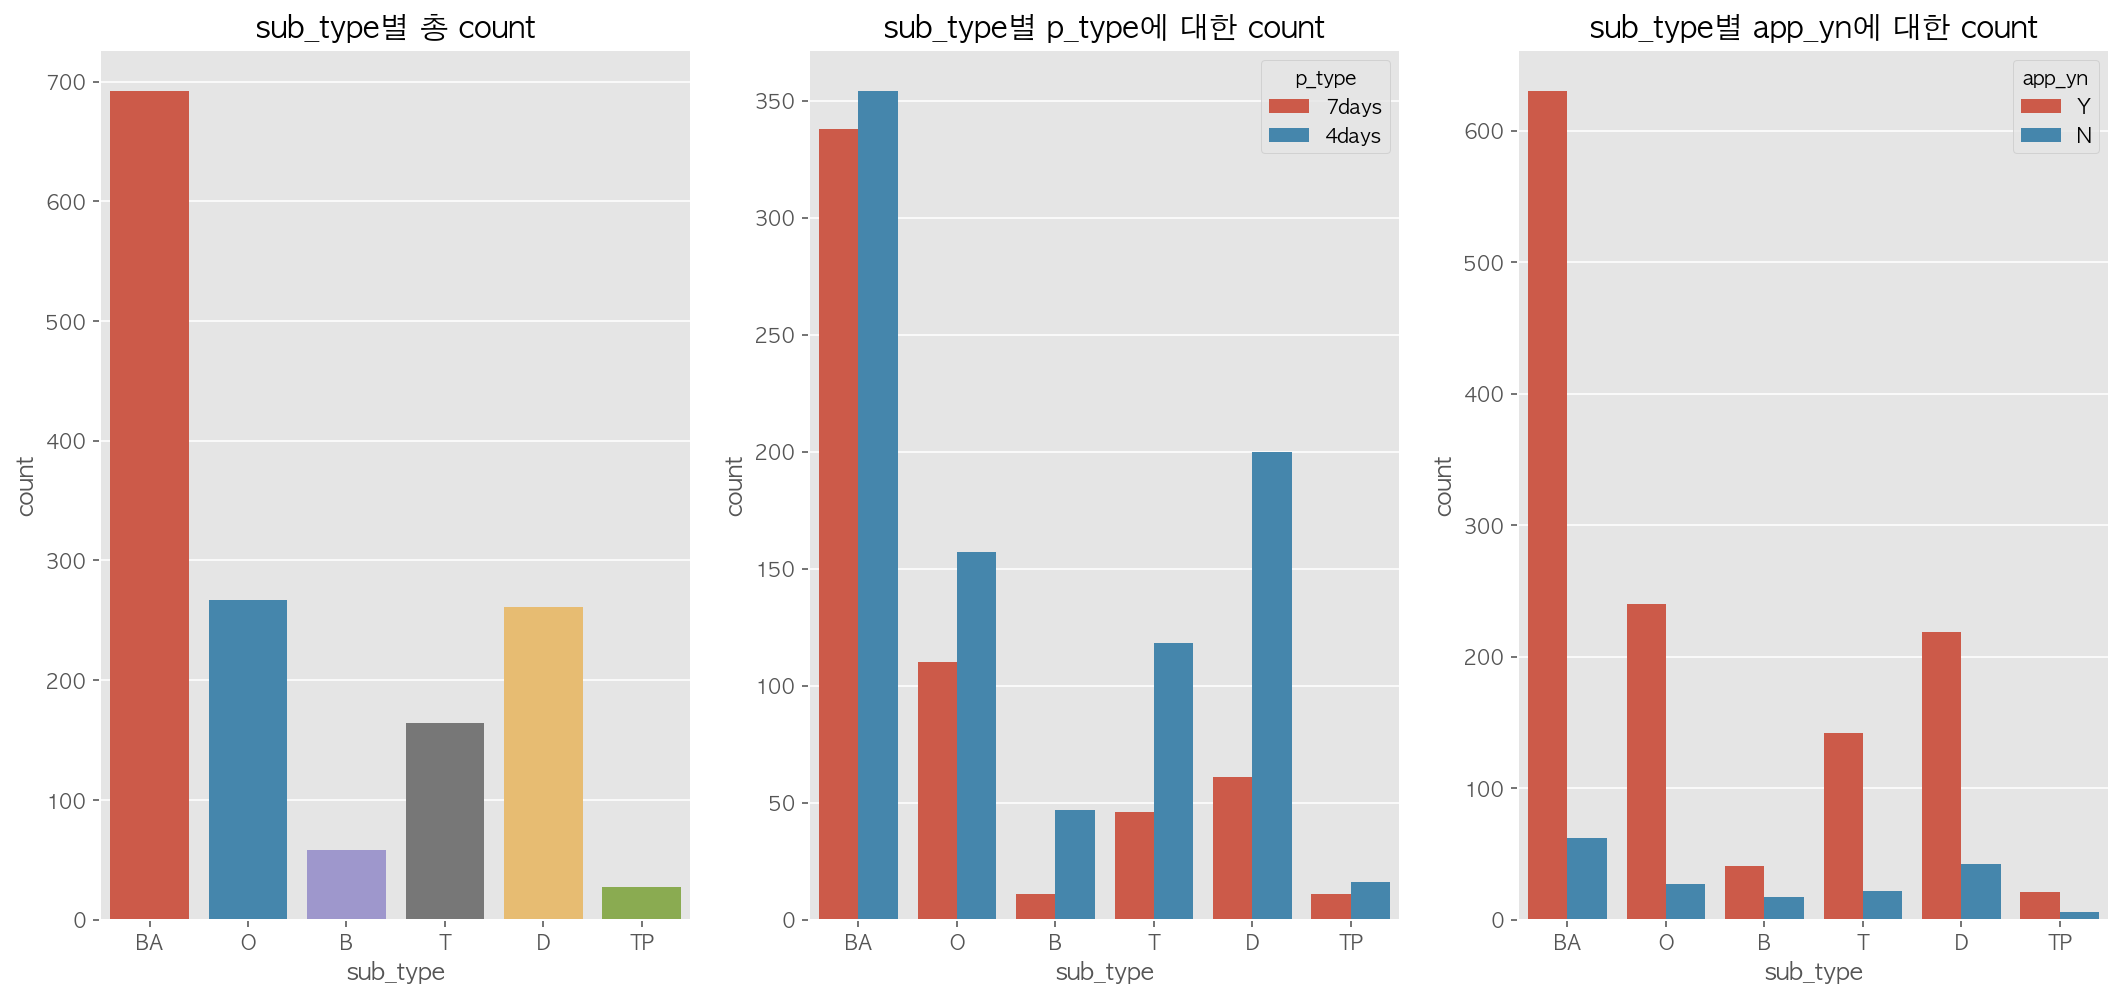

In [20]:
f, ax = plt.subplots(1, 3, figsize = (18,8))

sns.countplot(data=df, x='sub_type', ax=ax[0])
sns.countplot(data=df, x='sub_type', hue='p_type', ax=ax[1])
sns.countplot(data=df, x='sub_type', hue='app_yn', ax=ax[2])

ax[0].set_title("sub_type별 총 count", fontsize = 15)
ax[1].set_title("sub_type별 p_type에 대한 count", fontsize = 15)  
ax[2].set_title("sub_type별 app_yn에 대한 count", fontsize = 15)  
    
plt.show()

### 브랜드에 대한 선호도

In [21]:
# 상품별 많이 구매한 브랜드 top10 추출
sub_type = df['sub_type'].unique()

for i in sub_type :
    print(f"많이 구매한 브랜드 top10 - %s"%i)
    print(df[df['sub_type']==i].groupby('brandnm').count().sort_values(by='USER',ascending=False)['USER'].head(10))
    print("")

많이 구매한 브랜드 top10 - BA
brandnm
Gucci                 204
Saint Laurent          84
Louis Vuitton          77
Chanel                 75
Prada                  38
Yves Saint Laurent     34
Fendi                  23
Celine                 20
Christian Dior         15
Chloe                  12
Name: USER, dtype: int64

많이 구매한 브랜드 top10 - O
brandnm
Burberry           30
Max Mara           18
Prada              16
Chanel             13
Thom Browne        13
Balmain             7
Celine              7
Theory              7
Molliolli           7
Dolce & Gabbana     6
Name: USER, dtype: int64

많이 구매한 브랜드 top10 - B
brandnm
Sandro               3
Michaa               3
Thom Browne          3
Mine                 2
Calvin Klein         2
Alexander Mcqueen    1
Max Mara             1
Moia                 1
More Or Less         1
On&On                1
Name: USER, dtype: int64

많이 구매한 브랜드 top10 - T
brandnm
Thom Browne            17
Gucci                  14
Burberry               10
El estilo de Clai

### 색상에 대한 선호도 

In [22]:
data['component'] = data['goodsnm'].str.split()

In [23]:
data['color'] = 'none'

def color_ext(color):
    for i in range(len(data)):
        if (color in data['component'][i]): 
            data['color'].iloc[i]=color

In [24]:
color_list = ['beige','black','blue','pink','navy','ivory',
             'white','brown','cream','purple','deeppink',
             'nude','burgundy','grey','red',
            'skyblue', 'gold','mint','green','yellow',
             'collar','charcoal',' khaki','orange','lavender','mustard',
             'wine','salmon','rainbow','bluegreen','black&beige',
             'olive']

for i in color_list:
    color_ext(i)

In [25]:
# 중복 색 처리
for i in range(len(data)):
    if ('gray' in data['component'][i]):
       data['color'].iloc[i] = 'grey'
    if ('gray_1' in data['component'][i]):
       data['color'].iloc[i] = 'grey'
    if ('black1' in data['component'][i]):
       data['color'].iloc[i] = 'black'
    if ('black_1' in data['component'][i]):
       data['color'].iloc[i] = 'black'
    if ('Black' in data['component'][i]):
       data['color'].iloc[i] = 'black'

In [26]:
color = data.groupby('color').count()['USER'].sort_values(ascending=False)[:20].reset_index()

<AxesSubplot:xlabel='color', ylabel='USER'>

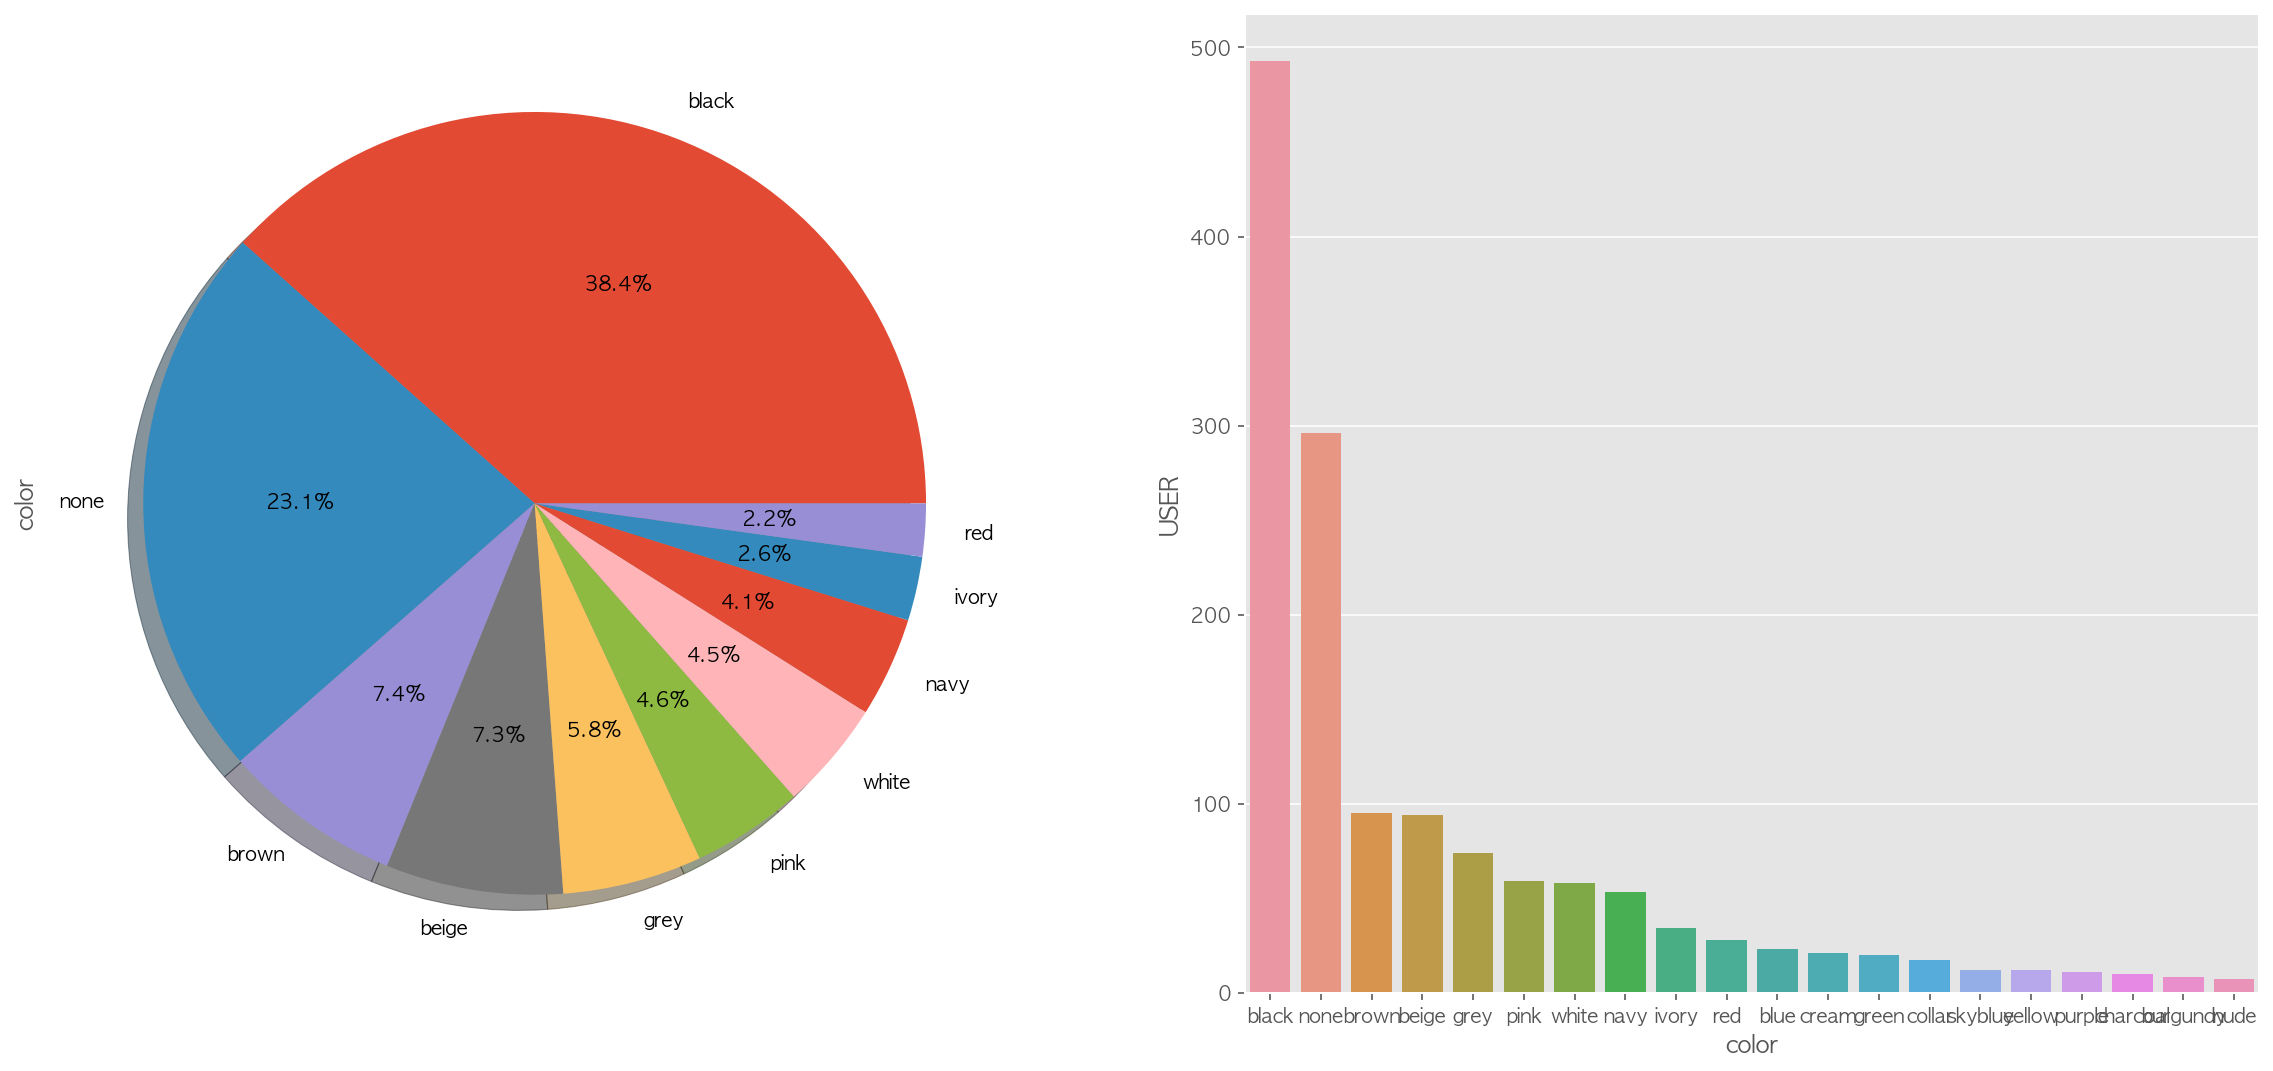

In [27]:
# 전체 아이템에 대한 색상 선호도
f, ax = plt.subplots(1,2, figsize = (20,9))

data['color'].value_counts()[:10].plot.pie(autopct = '%1.1f%%',shadow = True, ax=ax[0])
sns.barplot(data=color, x='color', y='USER', ax=ax[1])

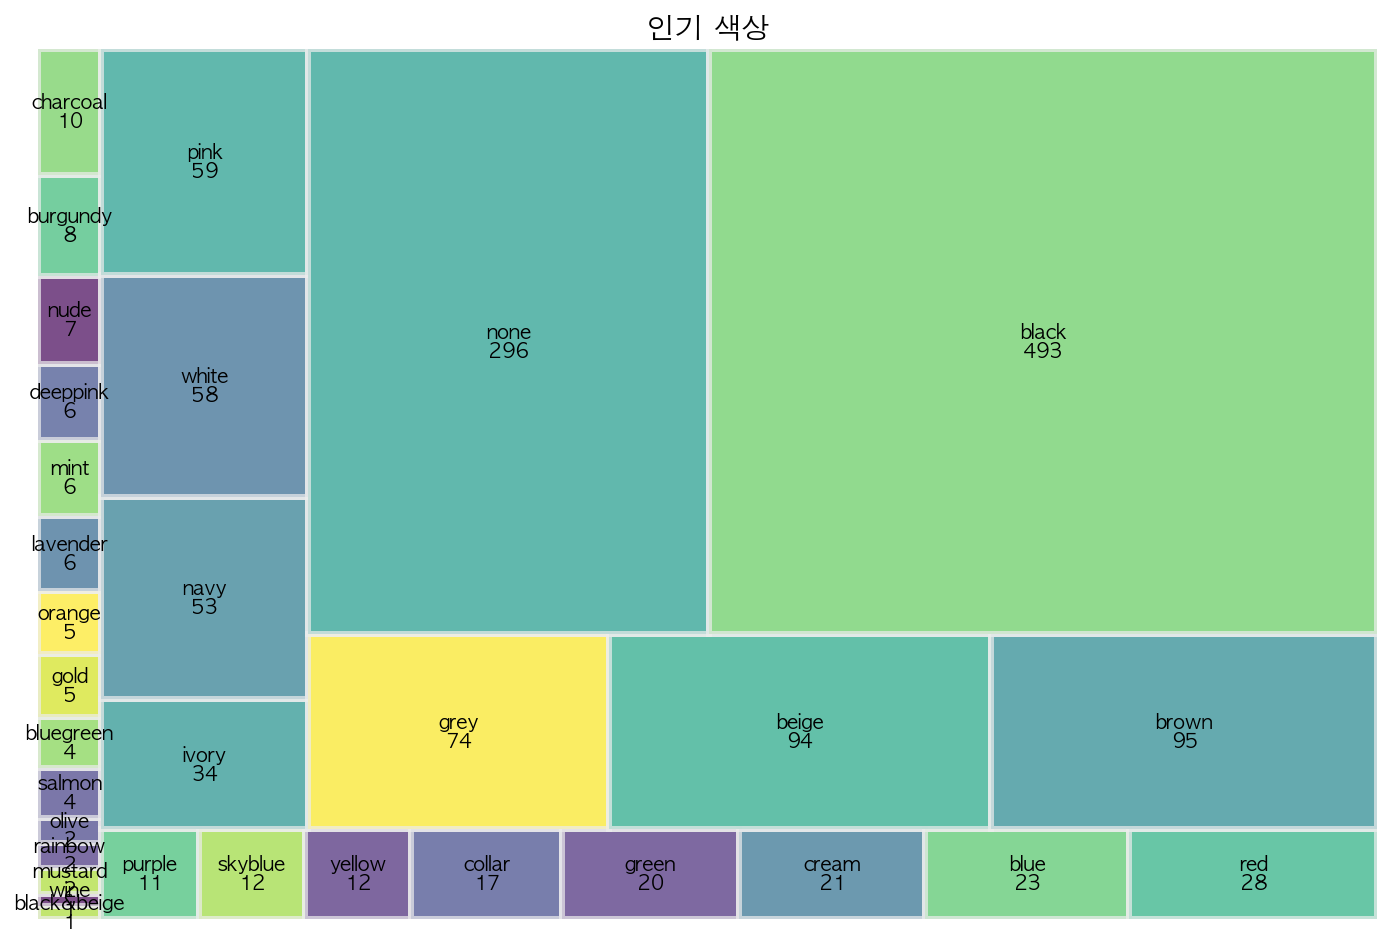

In [28]:
plt.figure(figsize=(12,8))
data_pivot = data.pivot_table(index = 'color', values = 'USER', aggfunc = 'count').sort_values('USER')
squarify.plot(sizes=data_pivot['USER'], label = data_pivot.index, value = data_pivot['USER'], alpha=0.7,bar_kwargs=dict(linewidth=3, edgecolor="#eee"))
plt.axis('off')
plt.title('인기 색상')
plt.show()

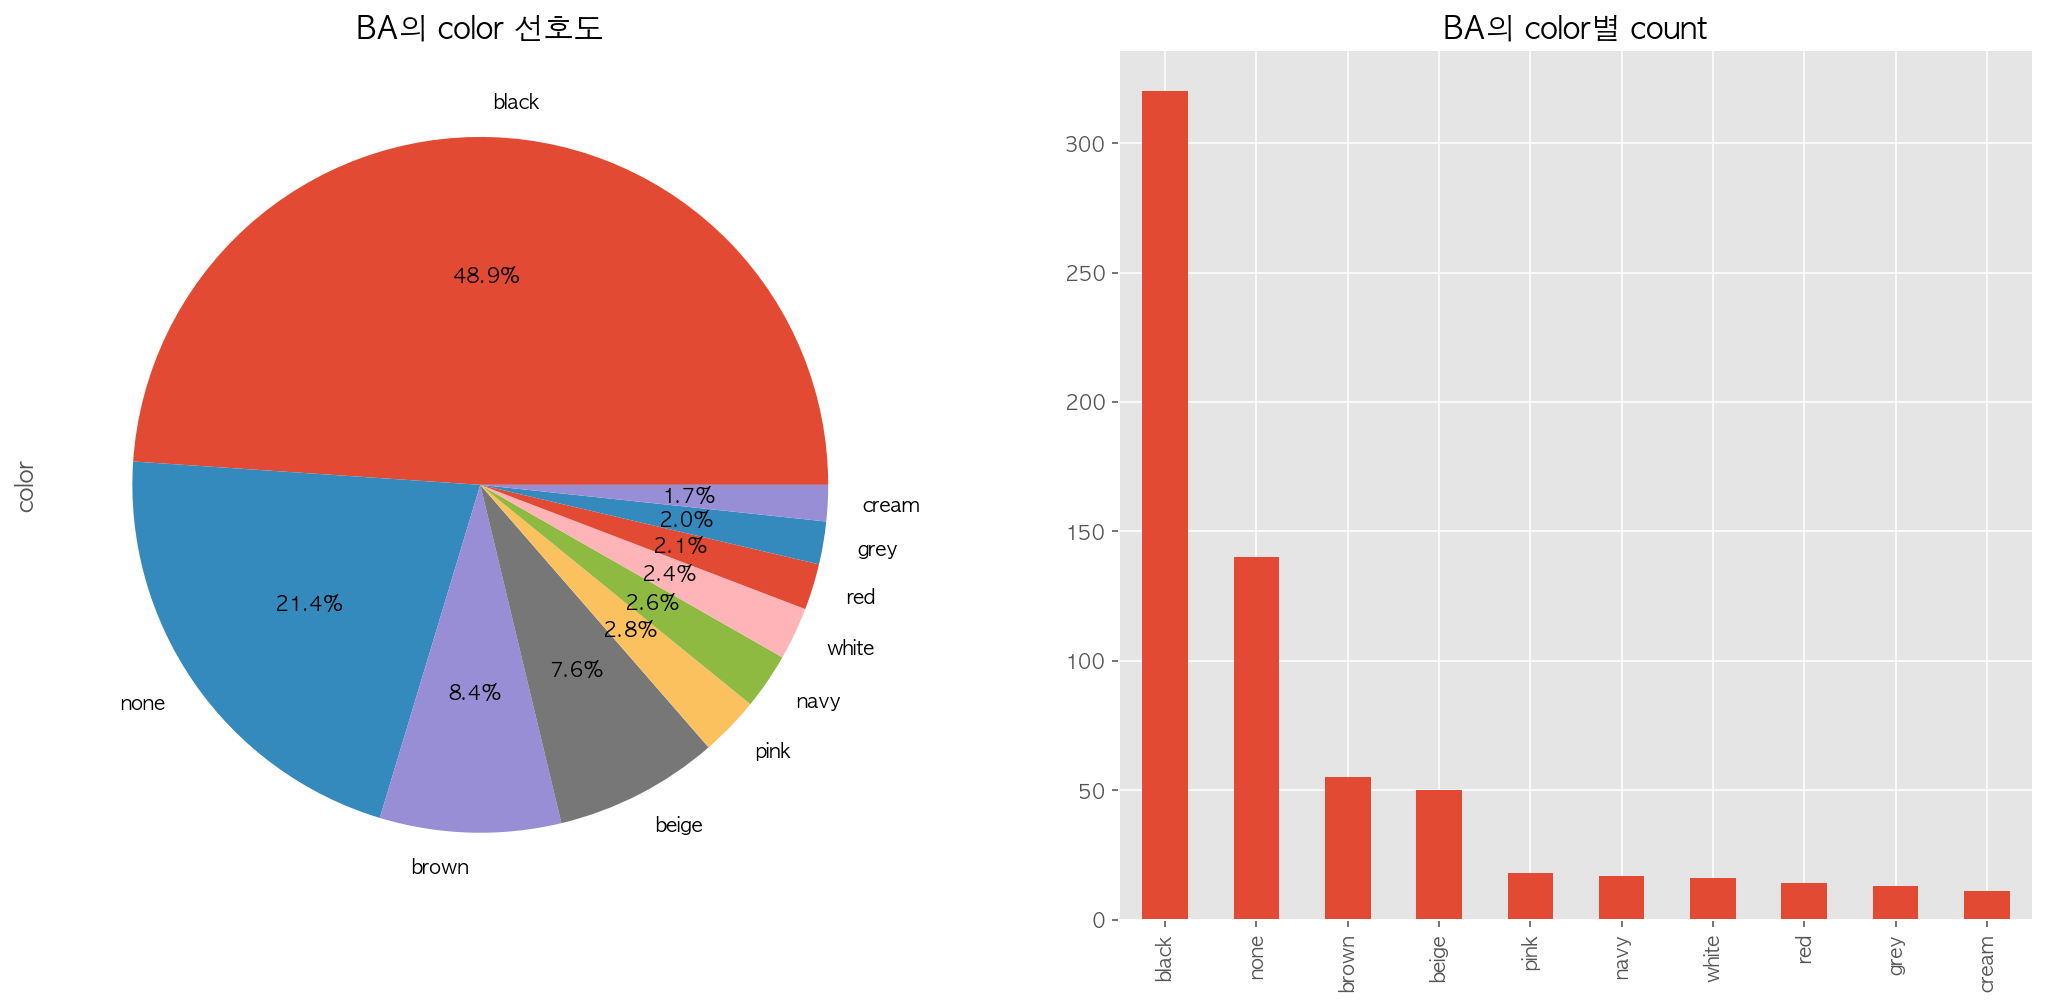

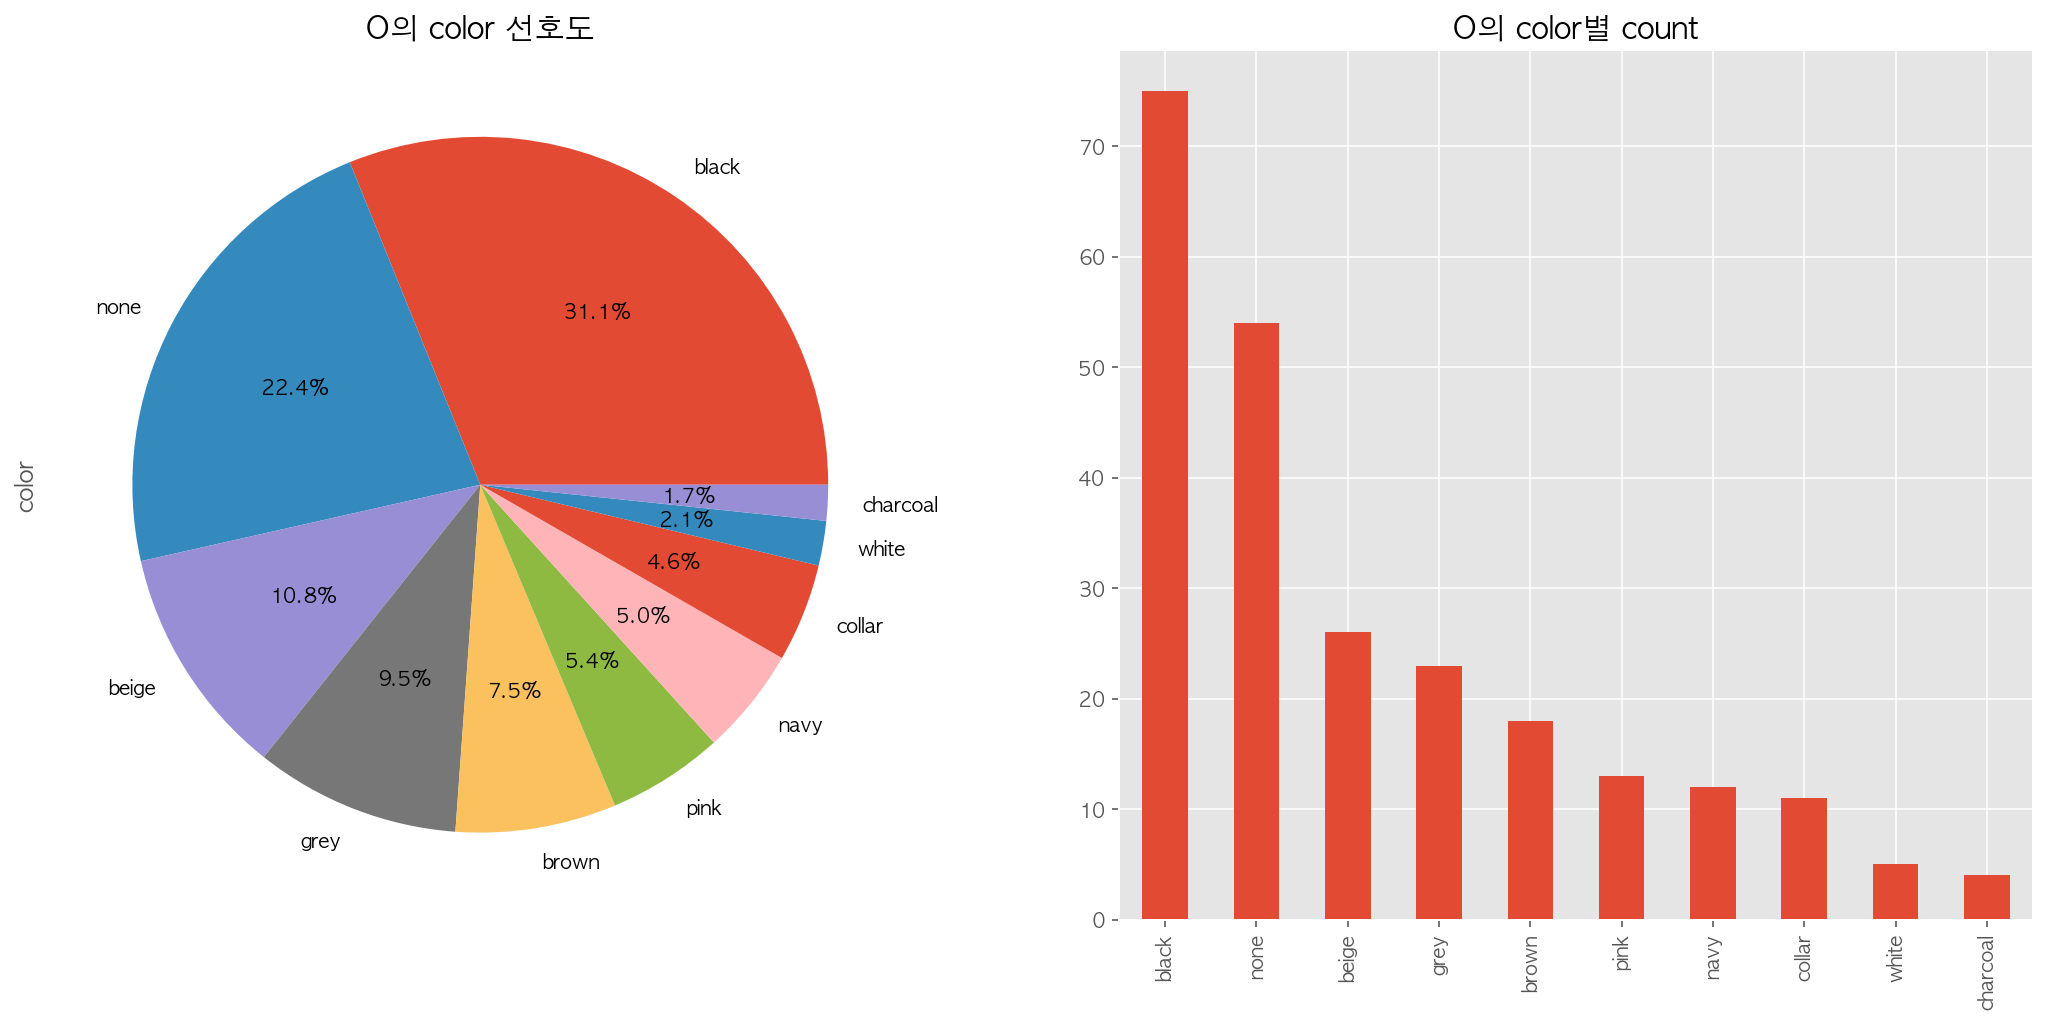

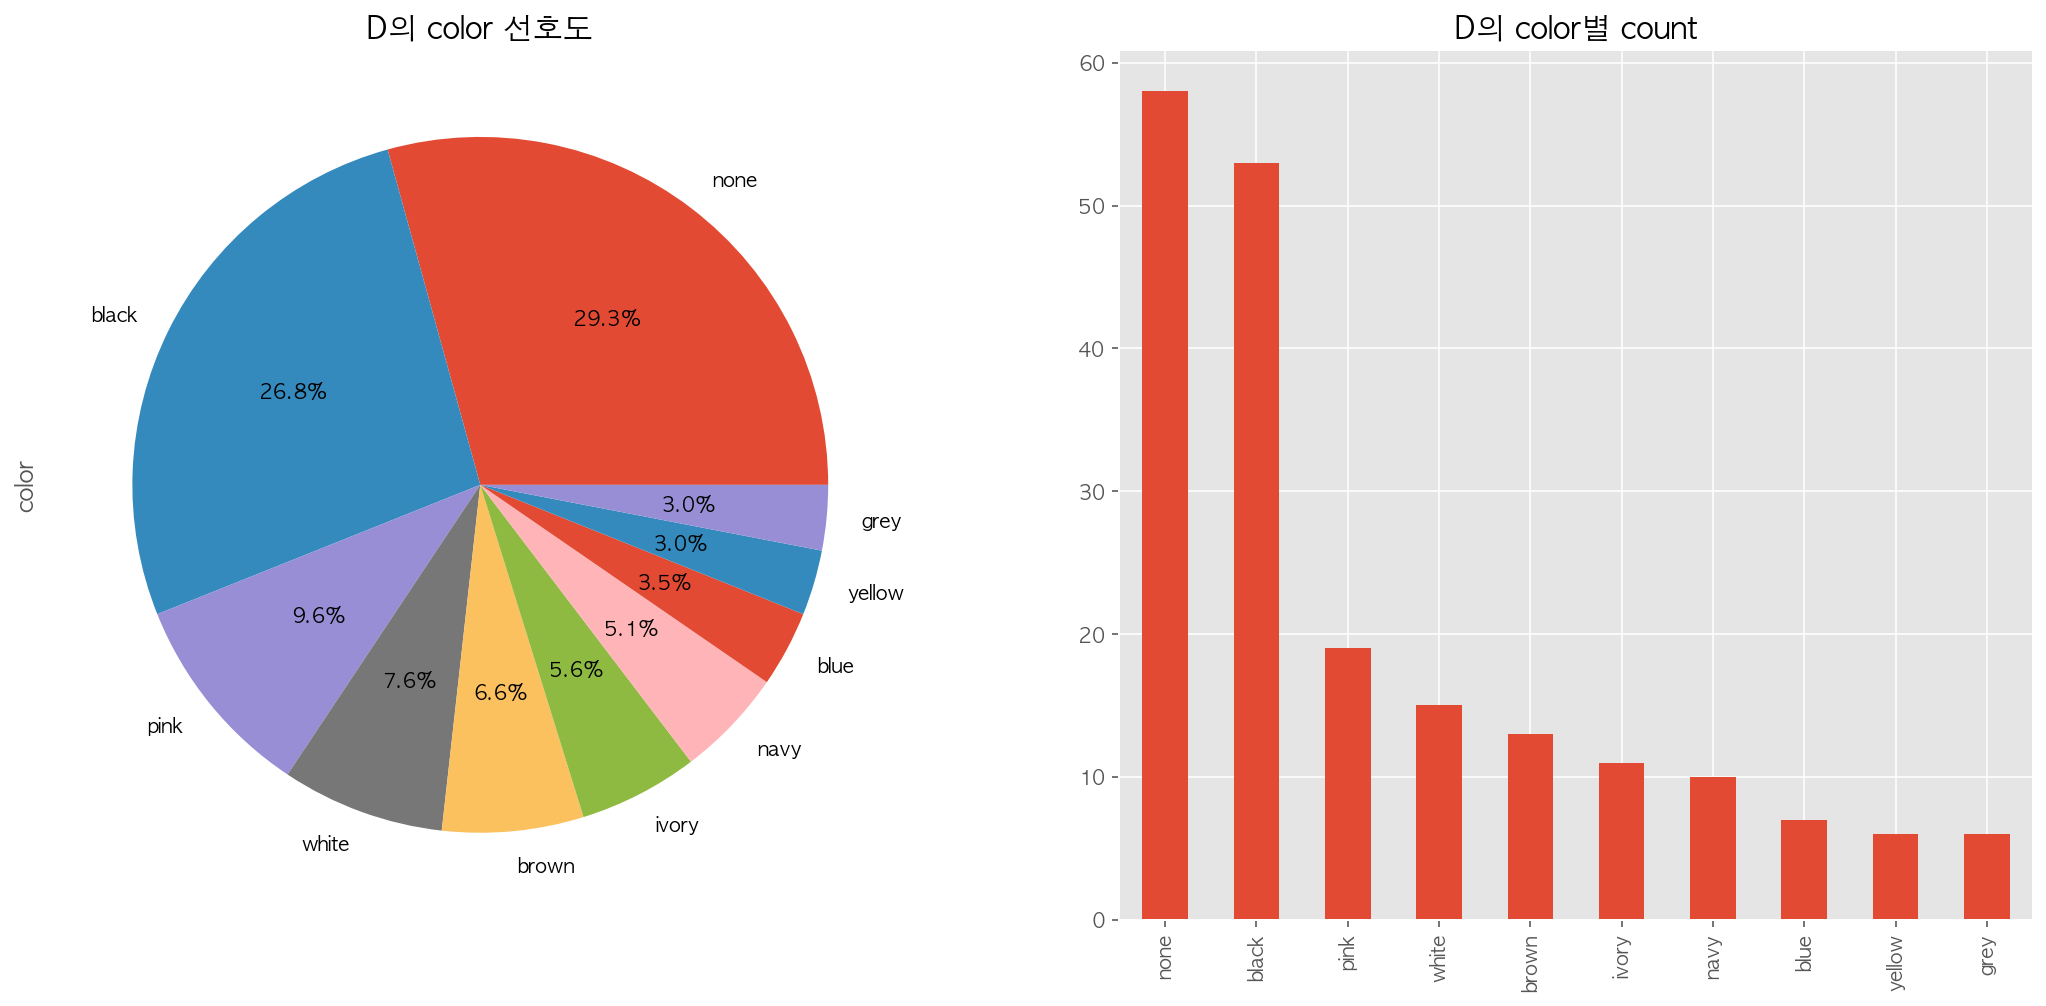

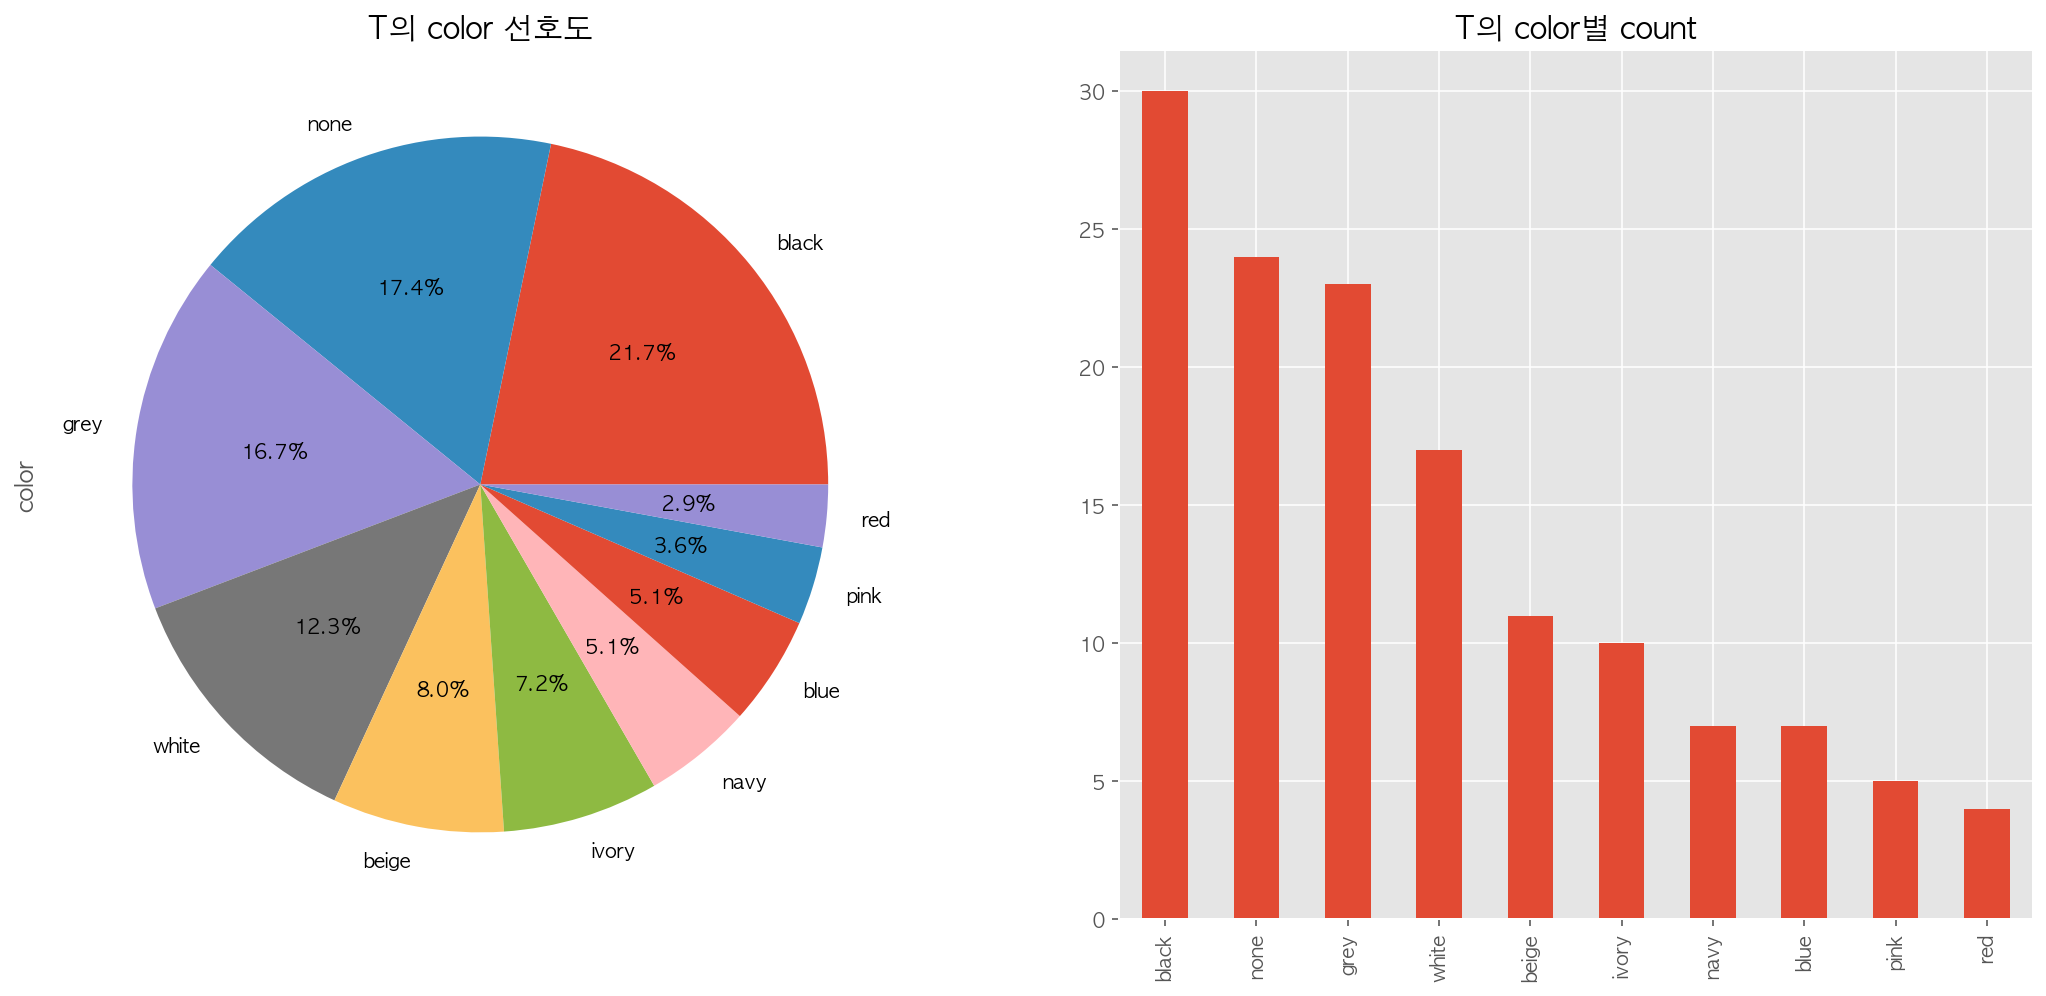

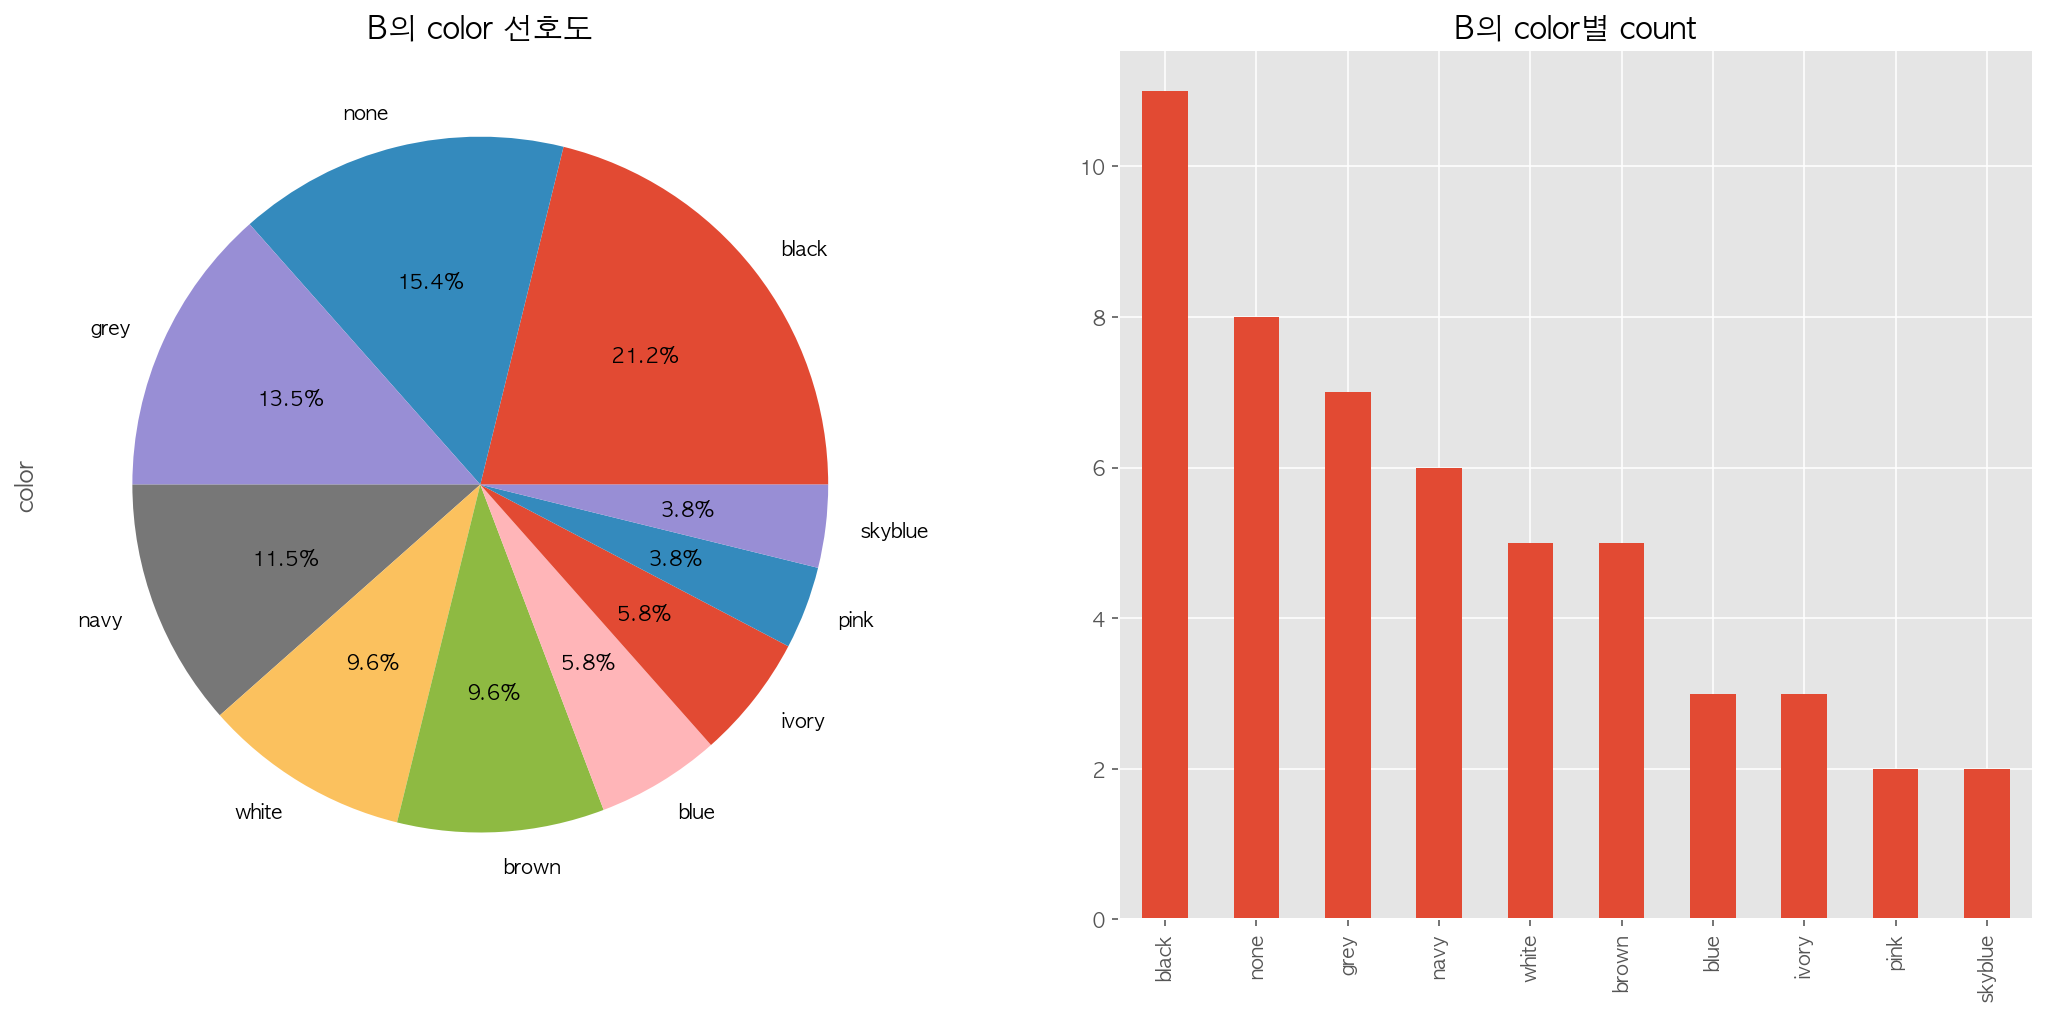

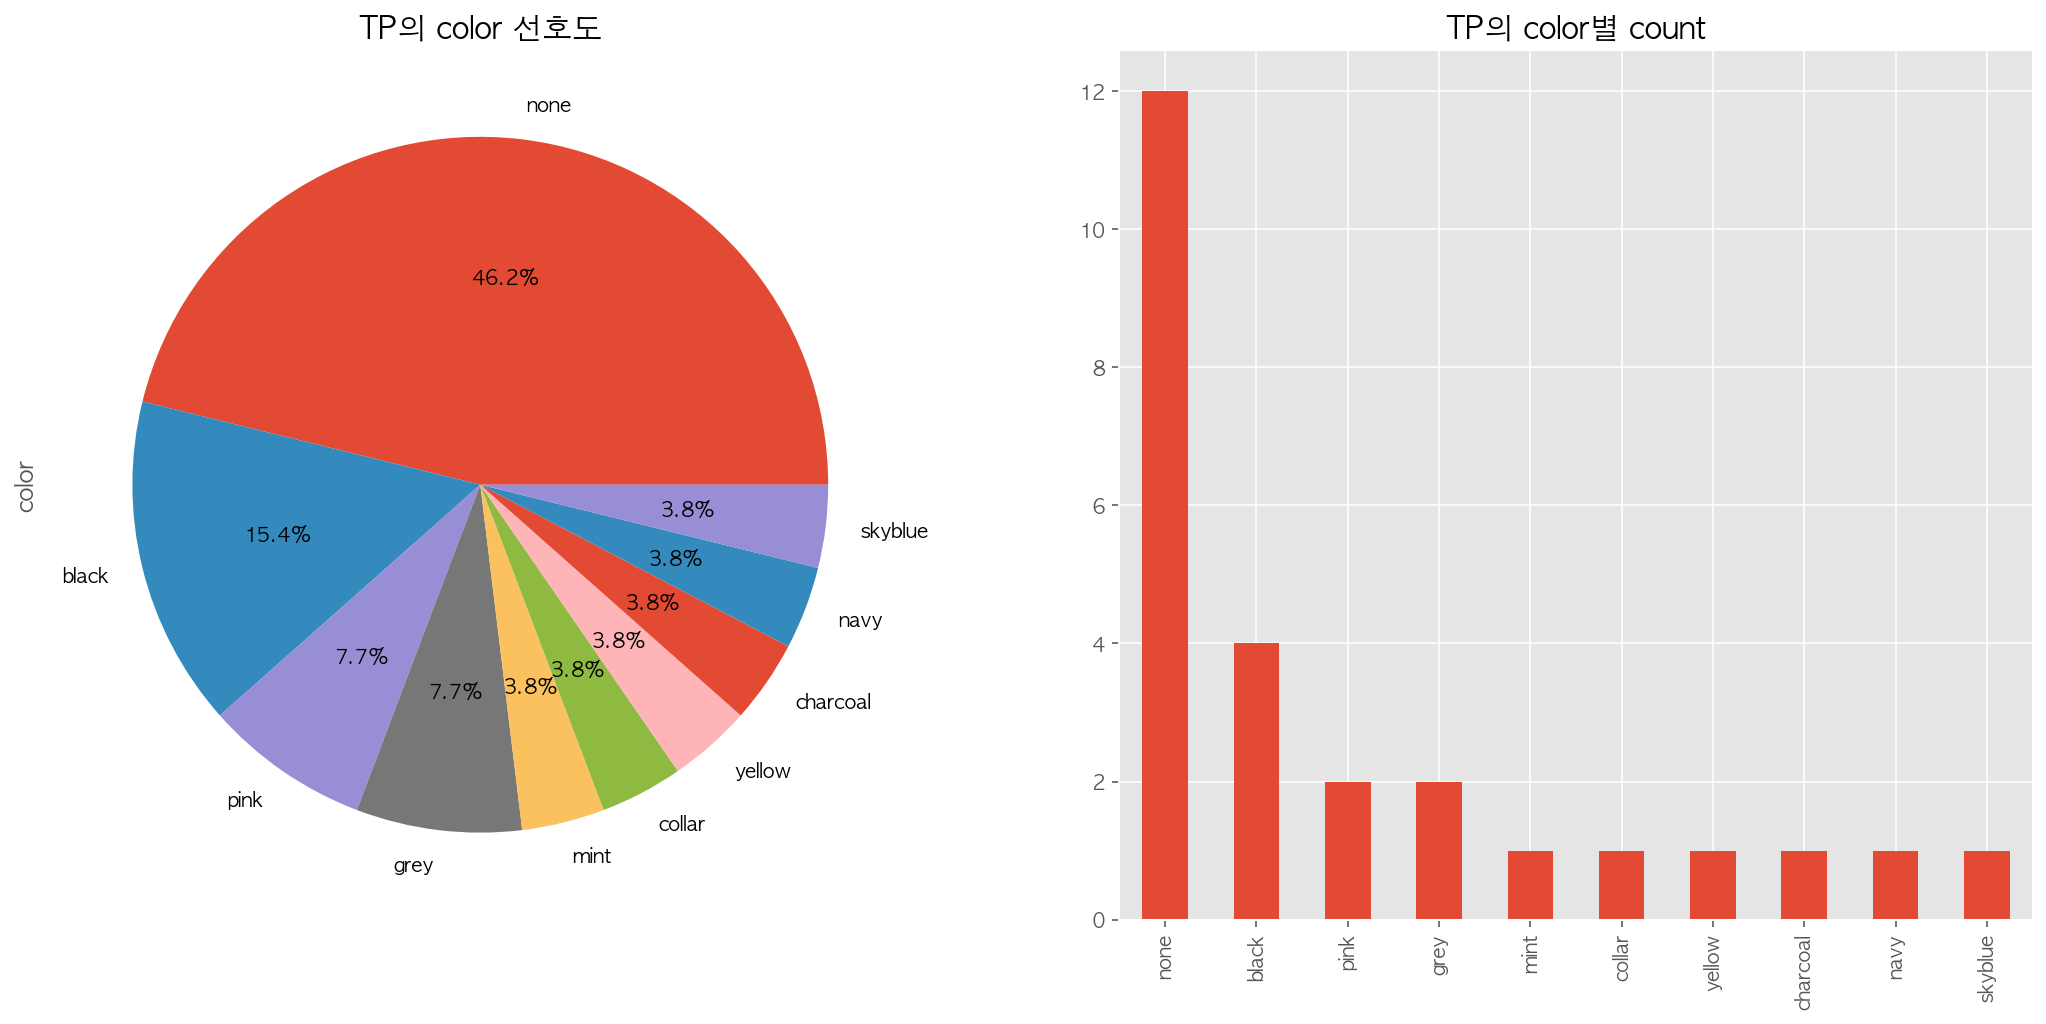

In [29]:
# 아이템 카테고리별 색상 선호도
list = data['sub_type'].value_counts().index

for i in list:
    f, ax = plt.subplots(1, 2, figsize = (18,8))

    data[data['sub_type']==i]['color'].value_counts()[:10].plot.pie(autopct = '%1.1f%%',shadow = False, ax=ax[0])
    data[data['sub_type']==i]['color'].value_counts()[:10].plot(kind='bar', ax=ax[1])

    ax[0].set_title("%s의 color 선호도"%i, fontsize = 15)
    ax[1].set_title("%s의 color별 count"%i, fontsize = 15)  

    plt.show()

### 제품에 대한 선호도

In [30]:
data['item'] = 'none'

def item_exit(item):
    for i in range(len(data)):
        if (item in data['component'][i]): 
            data['item'].iloc[i]=item

In [31]:
item_list = ['shoulder','jacket','skirt','top','zipup-jumper','coat',
             'fur-outer','cross','cardigan','padding','small',
             'hobo','dress','sweater','bucket',
            'sweat-shirts', 'jumper','turtle','body','lady',
             'clutch','mini',' shirt-dress','t-shirts','sleeveless','slacks',
             'blazer','medium', 'blouse', 'tote', 'belt', 'monogramtote',
            'hoodie', 'doublebreasted-jacket', 'duffle-coat', 'padding-outer',
            'crossbody', 'jump-suit', 'shirt', 'satchel', 'trench-coat', 'logo',
            'doublebreasted-coat', 'vest', 'shirts', 'way', 'chain',
            'singlebreated-jacket', 'box', 'dionysus', 'monogram', 'saffiano',
            'regular', 'moon', 'handle', '2jours', 'chino-pants', 'city',
            'tee', 'crossbody', 'satchel']

for i in item_list:
    item_exit(i)

In [32]:
# 중복 처리
for i in range(len(data)):
    if ('shoulder' in data['component'][i]):
       data['item'].iloc[i] = 'bag'
    if ('clutch' in data['component'][i]):
       data['item'].iloc[i] = 'bag'
    if ('mini' in data['component'][i]):
       data['item'].iloc[i] = 'bag'
    if ('logo' in data['component'][i]):
       data['item'].iloc[i] = 'bag'
    if ('tote' in data['component'][i]):
       data['item'].iloc[i] = 'bag'
    if ('cross' in data['component'][i]):
       data['item'].iloc[i] = 'bag'
    if ('chain' in data['component'][i]):
       data['item'].iloc[i] = 'bag'
    if ('body' in data['component'][i]):
       data['item'].iloc[i] = 'bag'

In [33]:
item = data.groupby('item').count()['USER'].sort_values(ascending=False)[:20].reset_index()

<AxesSubplot:xlabel='item', ylabel='USER'>

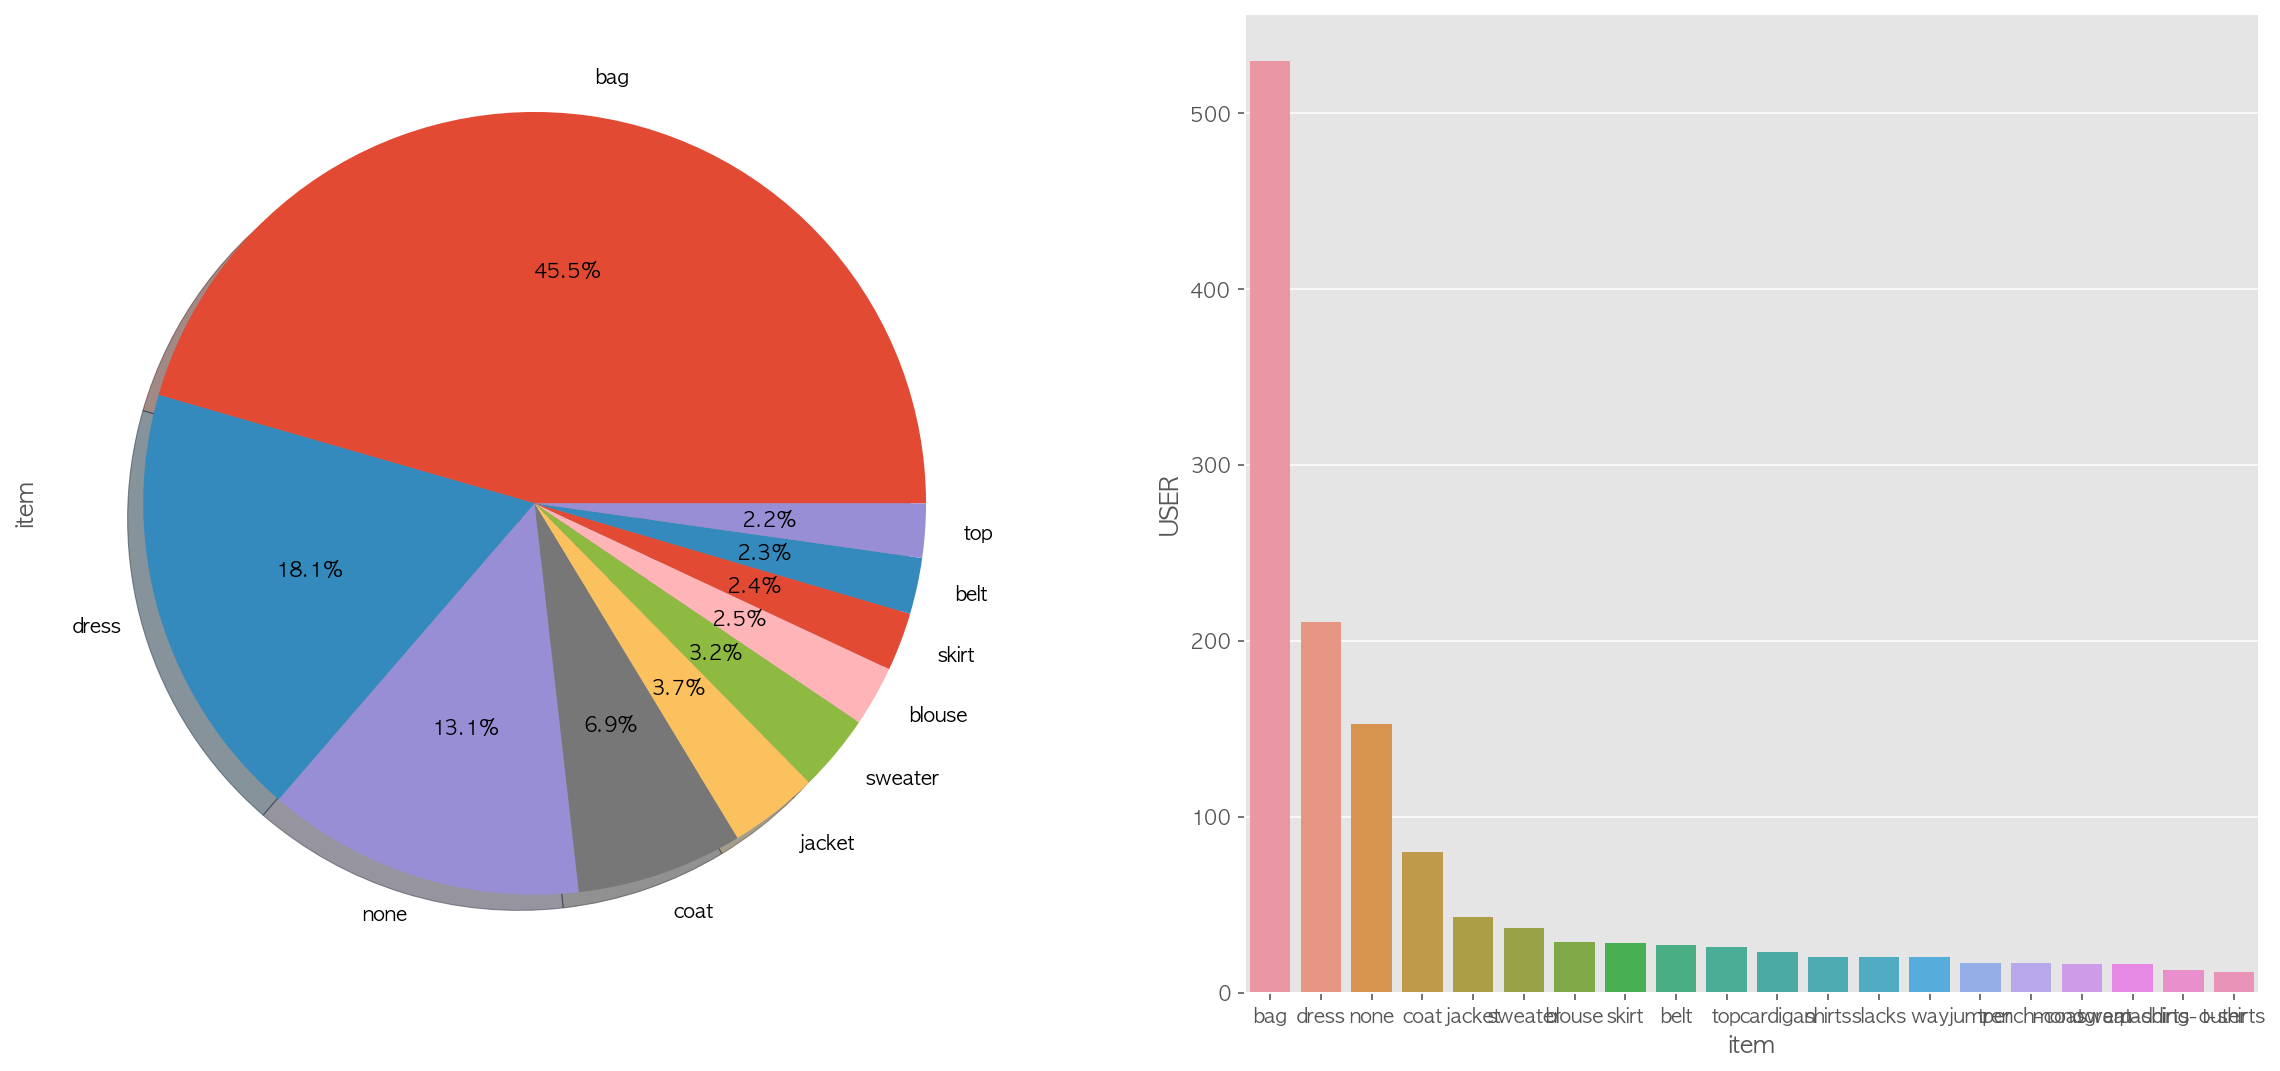

In [34]:
# 전체 아이템에 대한 제품 선호도
f, ax = plt.subplots(1,2, figsize = (20,9))

data['item'].value_counts()[:10].plot.pie(autopct = '%1.1f%%',shadow = True, ax=ax[0])
sns.barplot(data=item, x='item', y='USER', ax=ax[1])

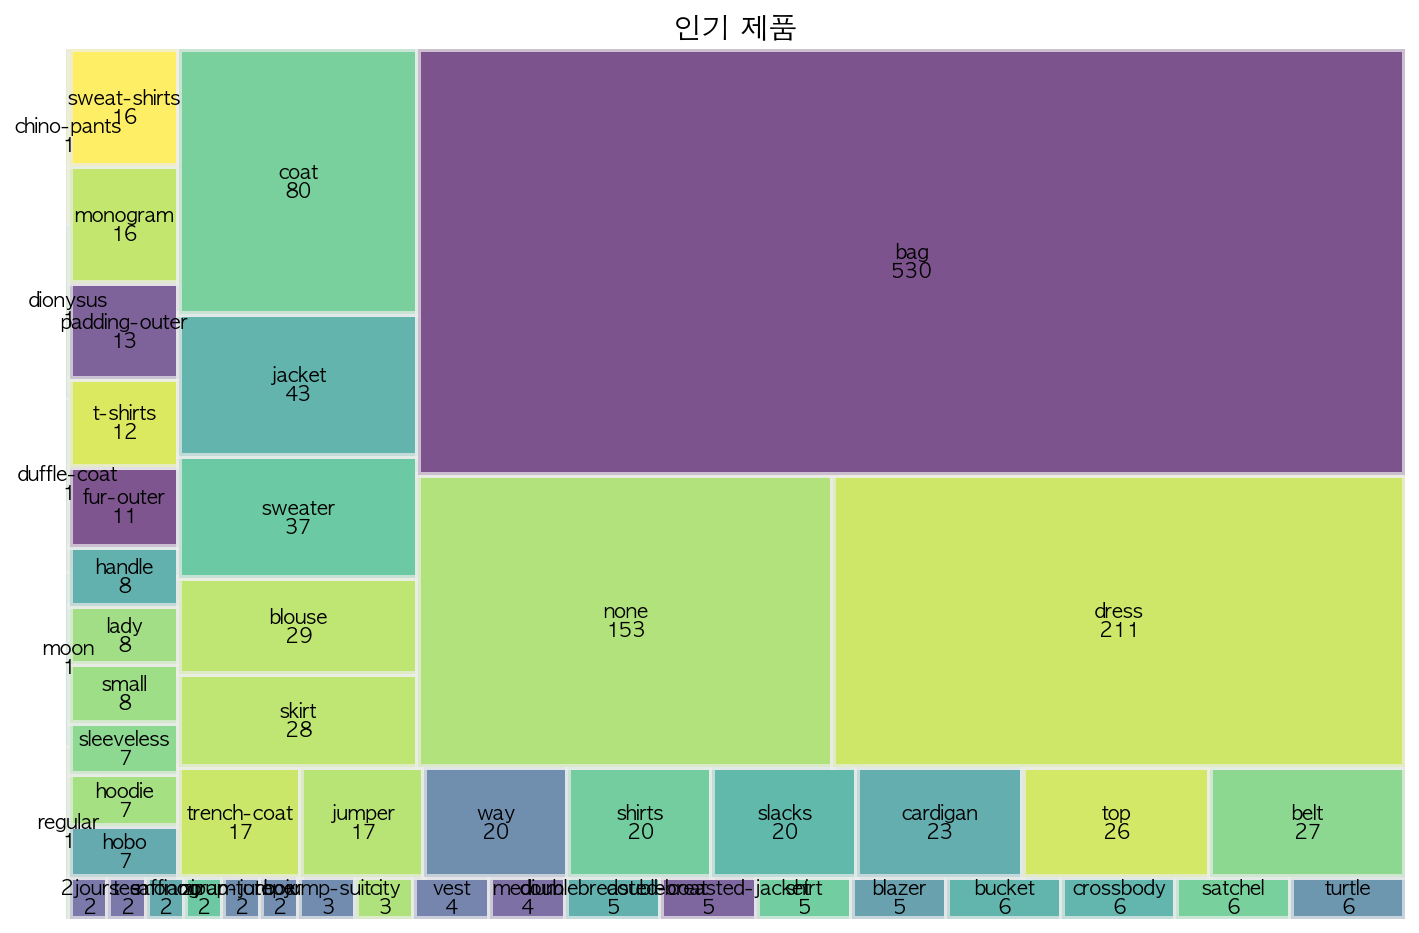

In [63]:
plt.figure(figsize=(12,8))
data_pivot = data.pivot_table(index = 'item', values = 'USER', aggfunc = 'count').sort_values('USER')
squarify.plot(sizes=data_pivot['USER'], label = data_pivot.index, value = data_pivot['USER'], alpha=0.7,bar_kwargs=dict(linewidth=3, edgecolor="#eee"))
plt.axis('off')
plt.title('인기 제품')
plt.show()

In [36]:
# BAG의 세부 제품 선호도 
bag = data.query('sub_type=="BA"').reset_index()
bag['item'] = 'none'

def item_exit(item):
    for i in range(len(bag)):
        if (item in bag['component'][i]): 
            bag['item'].iloc[i]=item

In [37]:
bag_list = ['tote','shoulder','cross','clutch','backpack',
            'belt','bucket','lady','luggage','emily','hobo']
    
for i in bag_list:
    item_exit(i)

# 중복처리    
for i in range(len(bag)):
    if ('crossbody' in bag['component'][i]):
       bag['item'].iloc[i] = 'cross'

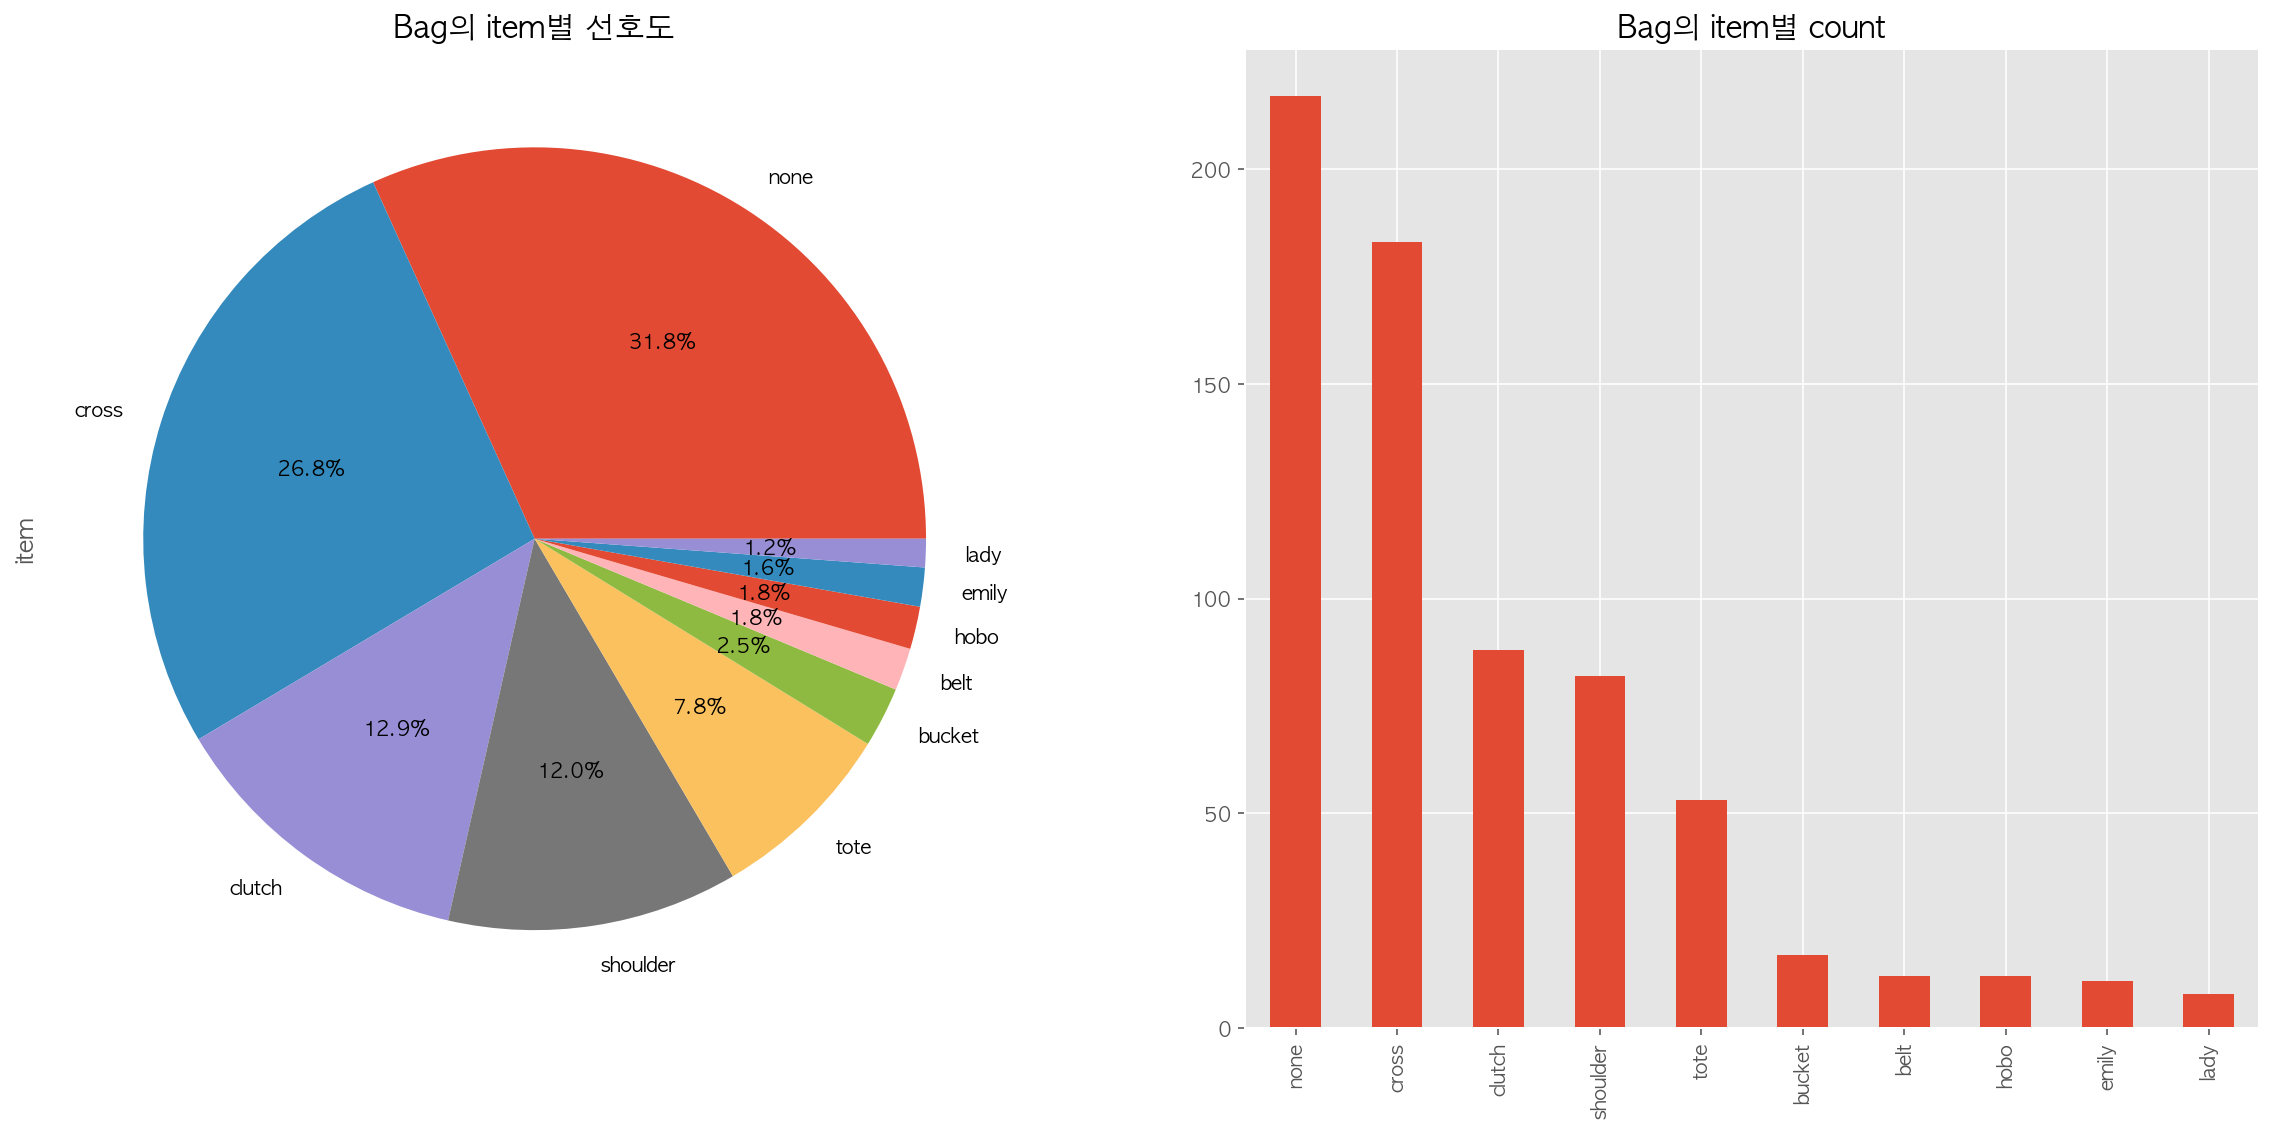

In [38]:
f, ax = plt.subplots(1,2, figsize = (20,9))

bag['item'].value_counts()[:10].plot.pie(autopct = '%1.1f%%',shadow = False, ax=ax[0])
bag['item'].value_counts()[:10].plot(kind='bar', ax=ax[1])

ax[0].set_title("Bag의 item별 선호도", fontsize = 15)
ax[1].set_title("Bag의 item별 count", fontsize = 15)  

plt.show()

In [39]:
# OUTER의 세부 제품 선호도 
import re
outer = data.query('sub_type=="O"').reset_index()

for i in range(len(outer)):
    outer['component'].iloc[i] = re.split(r'-| ', outer['goodsnm'][i])
    
outer['item'] = 0

def item_exit(item):
    for i in range(len(outer)):
        if (item in outer['component'][i]): 
            outer['item'].iloc[i]=item

In [40]:
outer_list = ['jacket','coat','fur','cardigan','padding','zip-up','cape','trench-coat','blazer','jumper']
    
for i in outer_list:
    item_exit(i)
    
# 중복처리    
for i in range(len(outer)):
    if ('zipup-jumper' in outer['component'][i]):
       outer['item'].iloc[i] = 'zip-up'
    if ('wrap-coat' in outer['component'][i]):
       outer['item'].iloc[i] = 'coat'
    if ('fullzip-jacket' in outer['component'][i]):
       outer['item'].iloc[i] = 'jacket'

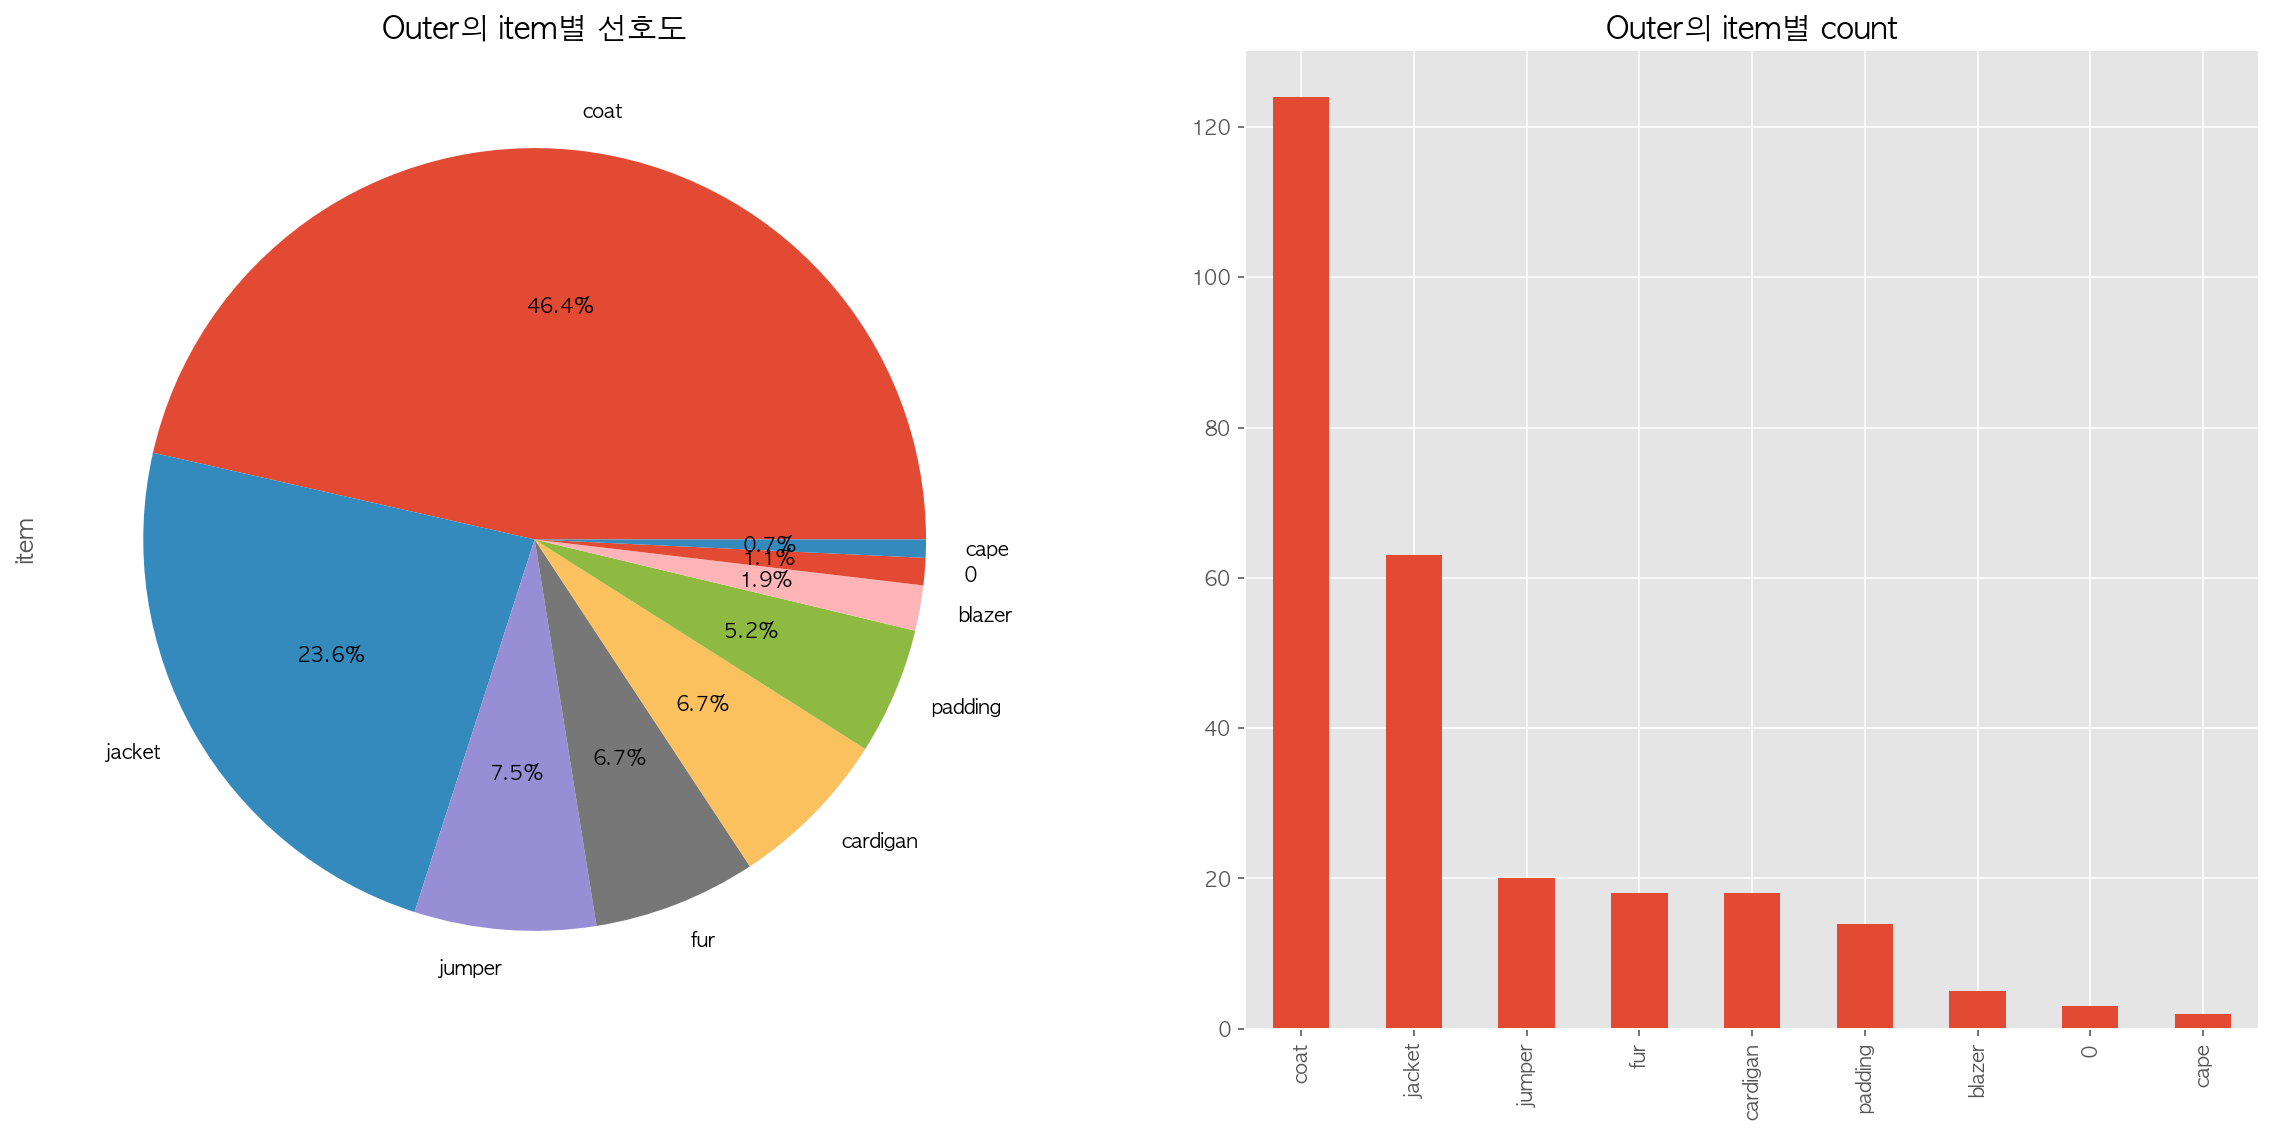

In [41]:
f, ax = plt.subplots(1,2, figsize = (20,9))

outer['item'].value_counts()[:10].plot.pie(autopct = '%1.1f%%',shadow = False, ax=ax[0])
outer['item'].value_counts()[:10].plot(kind='bar', ax=ax[1])

ax[0].set_title("Outer의 item별 선호도", fontsize = 15)
ax[1].set_title("Outer의 item별 count", fontsize = 15)  

plt.show()

### 첫 구매에 어떤 아이템을 구매할지 확인

In [42]:
temp = pd.DataFrame(data.groupby(['USER','sub_type']).count()['goodsnm'].unstack())
temp.head()

sub_type,B,BA,D,O,T,TP
USER,,,,,,
a1100548,1,1,NaN,NaN,NaN,NaN
a1100887,NaN,1,NaN,NaN,NaN,NaN
a1101514,NaN,NaN,NaN,1,NaN,NaN
a1101645,NaN,1,NaN,NaN,NaN,NaN
a1102068,NaN,1,NaN,NaN,NaN,NaN


In [43]:
# user의 첫구매의 sub_type 
print("유저가 첫구매에 B를 포함할 확률:",temp['B'].notnull().sum()/len(temp))
print("유저가 첫구매에 BA를 포함할 확률:",temp['BA'].notnull().sum()/len(temp))
print("유저가 첫구매에 D를 포함할 확률:",temp['D'].notnull().sum()/len(temp))
print("유저가 첫구매에 O를 포함할 확률:",temp['O'].notnull().sum()/len(temp))
print("유저가 첫구매에 T를 포함할 확률:",temp['T'].notnull().sum()/len(temp))
print("유저가 첫구매에 TP를 포함할 확률:",temp['TP'].notnull().sum()/len(temp))

유저가 첫구매에 B를 포함할 확률: 0.03571428571428571
유저가 첫구매에 BA를 포함할 확률: 0.5608766233766234
유저가 첫구매에 D를 포함할 확률: 0.17857142857142858
유저가 첫구매에 O를 포함할 확률: 0.2086038961038961
유저가 첫구매에 T를 포함할 확률: 0.10876623376623376
유저가 첫구매에 TP를 포함할 확률: 0.020292207792207792


### 이런 유저들의 retention rate 및 지속적인 신규 회원 유치를 위한 action plan은 추천 시스템이라고 생각

### 가장 인기있는 피쳐들 종합 
* 색상: 검은색
* 종류: 가방
* 브랜드: 구찌

## 추천 시스템 

### countvector를 사용한 version

In [44]:
count_vector = CountVectorizer()

In [45]:
goods_vector = count_vector.fit_transform(data['goodsnm'])
goods_vector

<1469x503 sparse matrix of type '<class 'numpy.int64'>'
	with 7263 stored elements in Compressed Sparse Row format>

In [46]:
# 코사인 유사도를 구한 벡터를 미리 저장
from sklearn.metrics.pairwise import cosine_similarity
goods_sim = cosine_similarity(goods_vector, goods_vector).argsort()[:,::-1]
print(goods_sim[:1])

[[   0  949  425 ...  594 1332  734]]


In [47]:
goods_sim.shape

(1469, 1469)

In [48]:
def find_sim(data, goods_name):
    # 특정 상품 정보 추출
    target_goodsnm_index = data[data['goodsnm']==goods_name].index.values
    
    # 코사인 유샤도 중 비슷한 코사인 유사도를 가진 정보 추출
    sim_index = goods_sim[target_goodsnm_index, :10].reshape(-1)
    # 본인 제외
    sim_index = sim_index[sim_index != target_goodsnm_index]
    
    # data frame 형성, vote_count로 정렬
    result = data.iloc[sim_index][:10]
    return result

In [49]:
find_sim(df, goods_name='buckle basic pattern zipup-jumper navy')

,brandnm,goodsnm,USER,reg_date,order_date,p_type,sub_type,app_yn,reg_date_ym,reg_date_w,reg_date_ymw,order_date_ym,order_date_w,order_date_ymw
135,Chanel,pocket graphics pattern zipup-jumper navy,a1112031,2020-08-15,2021-01-01,7days,O,N,20-08,3,20-08-3,21-01,1,21-01-1
291,ACNE STUDIOS,basic pattern sweater navy,a1143946,2021-01-21,2021-01-21,7days,T,Y,21-01,4,21-01-4,21-01,4,21-01-4
1302,Burberry London,basic pattern t-shirts navy,a187447,2020-03-09,2021-03-10,4days,T,N,20-03,3,20-03-3,21-03,2,21-03-2
381,Audrey Tailor,pocket basic pattern slacks navy,a1147589,2021-02-25,2021-02-28,7days,B,Y,21-02,4,21-02-4,21-02,4,21-02-4
392,Thom Browne,pocket basic pattern blazer navy,a1147623,2021-02-26,2021-02-26,4days,O,Y,21-02,4,21-02-4,21-02,4,21-02-4
1296,Valentino,pocket basic pattern slacks navy,a187924,2020-03-11,2021-03-10,7days,B,N,20-03,3,20-03-3,21-03,2,21-03-2
453,Jil Sander,strap basic pattern coat navy,a1122824,2020-10-06,2021-02-24,7days,O,Y,20-10,2,20-10-2,21-02,4,21-02-4
1303,System,pocket basic pattern slacks navy,a187447,2020-03-09,2021-03-10,4days,B,N,20-03,3,20-03-3,21-03,2,21-03-2
1268,Burberry,basic pattern wool sweater navy,a1149010,2021-03-11,2021-03-11,4days,T,Y,21-03,2,21-03-2,21-03,2,21-03-2


### TF-IDF를 활용한 version

In [50]:
# 많이 나오는 피쳐들 시각화를 위해 20으로 설정
tfidf = TfidfVectorizer(max_features = 20, max_df=0.95, min_df=0)

In [51]:
tfidf_matrix = tfidf.fit_transform(data['goodsnm'])
print(tfidf_matrix.shape)

(1469, 20)


In [52]:
# 제일 많이 나오는 20개의 피쳐 확인
tfidf_dict = tfidf.get_feature_names()
print(tfidf_dict)

['bag', 'basic', 'beige', 'black', 'brown', 'button', 'chain', 'check', 'clutch', 'coat', 'cross', 'detail', 'dress', 'jacket', 'line', 'monogram', 'pattern', 'pocket', 'quilted', 'shoulder']


In [53]:
data_array = tfidf_matrix.toarray()
df_data = pd.DataFrame(data_array, columns=tfidf_dict)
data.shape

(1469, 14)

In [54]:
# 2차원 배열로 바꾸어줌
tsne = TSNE(n_components=2, n_iter=10000, verbose=1)

In [55]:
data_array.T.shape

(20, 1469)

In [56]:
# 시각화를 위한 변환
Z = tsne.fit_transform(data_array.T)

[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.000s...
[t-SNE] Computed neighbors for 20 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 20 / 20
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.551006
[t-SNE] KL divergence after 1500 iterations: 0.404965


In [57]:
print(Z[0:5])
print('Top words: ',len(Z))

[[  -0.95606136  -91.96834   ]
 [ -87.161476     98.263275  ]
 [ -65.325424    -57.93099   ]
 [-119.29023    -101.28282   ]
 [ -50.192463   -202.7997    ]]
Top words:  20


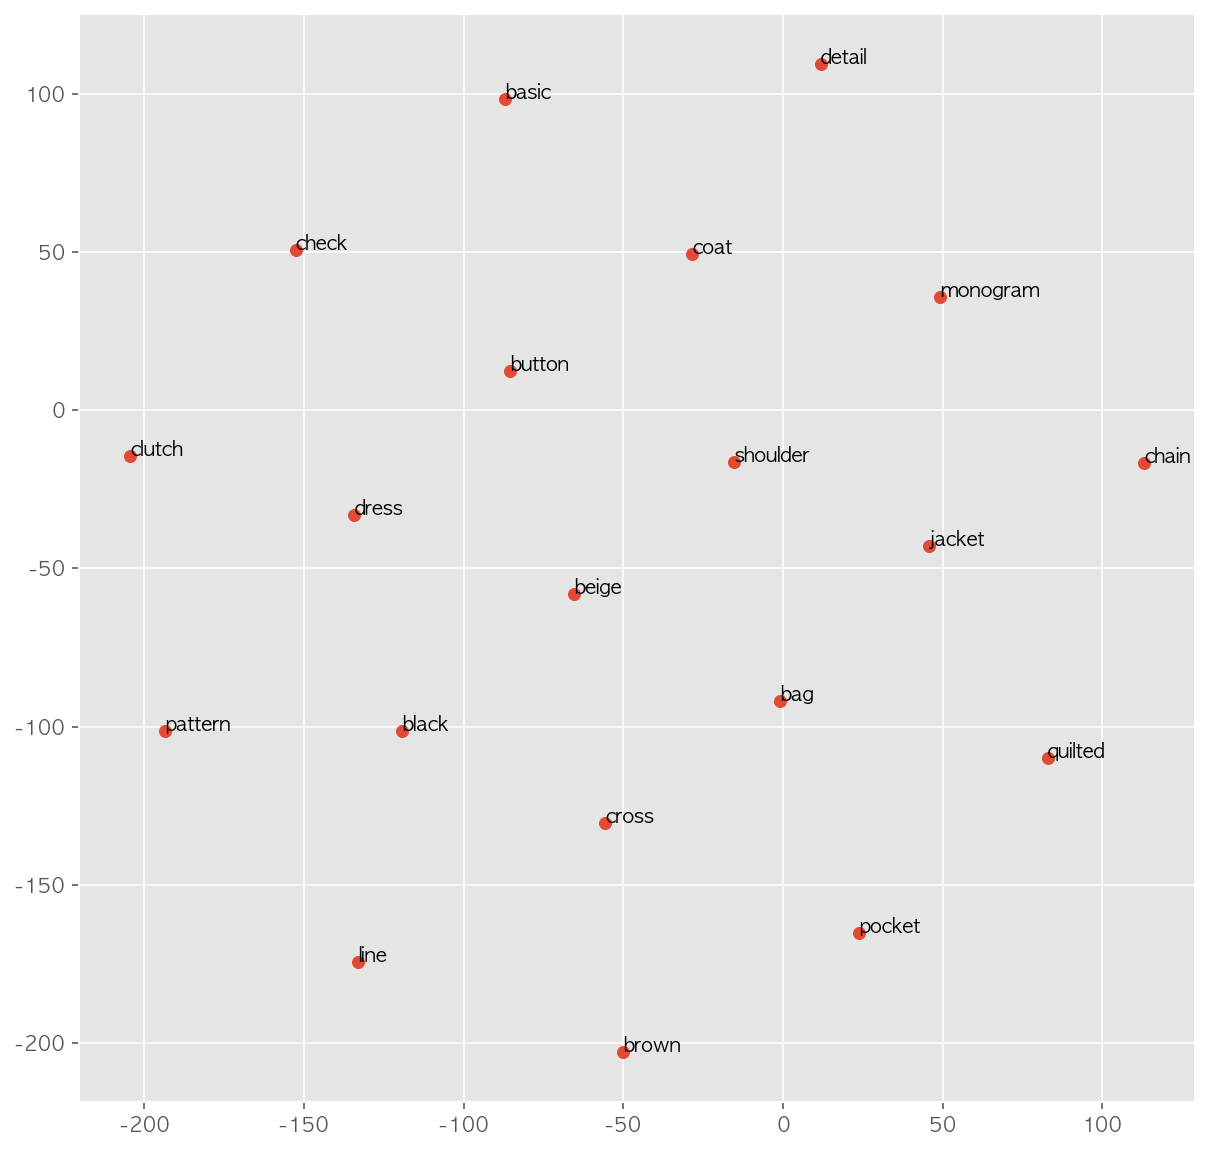

In [58]:
plt.figure(figsize=(10, 10))
plt.scatter(Z[:,0], Z[:,1])
for i in range(len(tfidf_dict)):
    plt.annotate(s=tfidf_dict[i].encode("utf8").decode("utf8"), xy=(Z[i,0], Z[i,1]))

plt.draw()

In [59]:
cosine_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_matrix.shape

(1469, 1469)

In [60]:
title2idx = {}
for i, c in enumerate(data['goodsnm']): 
    title2idx[i] = c

In [61]:
idx2title = {}
for i, c in title2idx.items(): 
    idx2title[c] = i

In [62]:
# 값을 기반으로 한 추천 
idx = idx2title['pocket graphics pattern sweat-pants white']
sim_scores = [(i, c) for i, c in enumerate(cosine_matrix[idx]) if i != idx] 
sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse=True) 
sim_scores[0:10]
sim_scores = [(title2idx[i], score) for i, score in sim_scores[0:10]]
sim_scores

[('pocket graphics pattern zipup-jumper navy', 1.0000000000000002),
 ('pocket graphics pattern hoodie yellow', 1.0000000000000002),
 ('pocket color block pattern fur-outer', 1.0000000000000002),
 ('pocket stripe pattern shirts pink', 1.0000000000000002),
 ('pocket Quilting pattern padding-outer khaki', 1.0000000000000002),
 ('pocket lettering pattern hoodie black', 0.9004673539675544),
 ('pocket stripe pattern slacks black', 0.9004673539675544),
 ('pocket basic pattern fur-outer ivory', 0.8589521725473193),
 ('pocket basic pattern fur-outer pink', 0.8589521725473193),
 ('pocket basic pattern fur-outer grey', 0.8589521725473193)]